# Introduction

The following notebook accompanies *Transcranial Ultrasound Sonication at Sub-Cubic Millimeter Resolution with Standing Waves via a Pair of Orthogonal Transducers*, by Kasra Naftchi-Ardebili, Mike D. Menz, Hossein Salahshoor, Gerald R. Popelka, Stephen A. Baccus, and Kim Butts Pauly. 

In part **1** of this notebook we load and plot the simulation data.  In part **2** we offer a thorough introduction to second-order approximation of acoustic radiation force (ARF). In that same section we compute the ARF for single and orthogonal pair of transducers with and without the simplifying quasi planar and purely planar assumptions.  Relevant figures are provided to highlight the effects of these assumptions in both scenarios. In part **3** we derive the $2\alpha I/c$ relationship commonly used for ARF.  In part **4** we analyze the spatial resolution of the orthogonal transducers, as defined by the FWHM at -3 dB intensity.
And finally in part **5** we create rest of the publication figures. 


Most of the functions that generate the figures are saved in the ```helper_functions.py``` script. Make sure to import that file. Pressure fields and non-staggered particle velocities are simulated using the *k-Wave* toolbox. Each transducer is a single-element 2D curve with a $30\ \text{mm}$ aperture and a focal radius of $30\ \text{mm}$ ($f\#=1$). Propagating medium is considered to be water and the grid resolution is $0.1\ \text{mm}$ in each direction. The center frequency of the transducers is assumed to be $1\ \text{MHz}$, with a surface pressure of $1\ \text{MPa}$. The results are provided in ```single_trxd.mat``` and ```orthogonal_trxd.mat```. With minimal modifications, you can use this code on your data. 


Author: Kasra Naftchi-Ardebili (knaftchi@stanford.edu)

Date: July $13^{th},\ 2021$

Kim Butts Pauly Group, Stanford University

In [1]:
# import the necessary libraries 
from helper_functions import *

import matplotlib.pyplot as plt
plt.style.use('bmh')
%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False

In [2]:
# define the data class for easier parsing
class SimSetup:
    def __init__(self, data):
        self.pressure = data['sensor_data']['p']
        self.max_pressure = data['sensor_data']['p_max']
        self.vx = data['sensor_data']['ux_non_staggered']
        self.vy = data['sensor_data']['uy_non_staggered']

    # define a function that returns the intensity in dB scale
    def dB_intensity(self):
        return 20 * np.log10(self.max_pressure / np.max(self.max_pressure))

# 1.&nbsp;Simulation Data


## 1.1. Load the Data
First we will load and visualize the data before moving on to computing the acoustic radiation force (ARF). First, let's load the ``.mat`` files that contain the sensor data from *k-Wave* simulations. 

I have made the ``.mat`` files public so you can download them and try the code:

single transducer: 
https://drive.google.com/file/d/1LVHbROgv94fVb8M5T8ODiEDZqCzf6W94/view?usp=sharing

orthogonal transducers:
https://drive.google.com/file/d/14y7LhrRrk3BJwVDviZDIp5CIpvUhG4AK/view?usp=sharing

In [3]:
# # import the data
# !gdown -O single_trxd_mat 'https://drive.google.com/uc?id=1LVHbROgv94fVb8M5T8ODiEDZqCzf6W94' 
# !gdown -O orthogonal_trxd_mat 'https://drive.google.com/uc?id=14y7LhrRrk3BJwVDviZDIp5CIpvUhG4AK' 

In [4]:
path = '/Users/kasra/Library/CloudStorage/GoogleDrive-knaftchi@stanford.edu/\
My Drive/Pauly Lab/Paper Submissions/Crossbeam/ARF/'

# download the data
# #### uncomment below if downloading the data via !gdown command ####
# single_trxd_raw = h5py.File('/Users/kasra/Library/CloudStorage/GoogleDrive-knaftchi@stanford.edu/My Drive/\
# Pauly Lab/Paper Submissions/Crossbeam/ARF/code/single_trxd_mat', 'r')
# orthogonal_trxd_raw = h5py.File('/Users/kasra/Library/CloudStorage/GoogleDrive-knaftchi@stanford.edu/\
# My Drive/Pauly Lab/Paper Submissions/Crossbeam/ARF/code/orthogonal_trxd_mat', 'r')


#### uncomment below if downloading the data locally ####
single_trxd_raw = h5py.File(path + 'data/single_trxd.mat', 'r')
orthogonal_trxd_raw = h5py.File(path + 'data/orthogonal_trxd.mat', 'r')

In [5]:
single_trxd = SimSetup(single_trxd_raw)
orthogonal_trxd = SimSetup(orthogonal_trxd_raw)

In [6]:
# # mount Google Drive (if using Google Drive) to save the figures
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
# set the path to saving the figures
#figure_path = '/content/drive/My Drive/Pauly Lab/Paper Submissions/Crossbeam/figures/'
figure_path = path + '/figures/'

In [8]:
# simulation setup 
Nx = 500      # grid points 
Ny = 500      # grid points 
dx = 0.1e-3   # m (spatial resolution in x)
dy = 0.1e-3   # m (spatial resolution in y)
Nt = 2358     # time steps 
dt = 20e-9    # s (temporal resolution)
rho = 1000    # kg/m3
c = 1500      # m/s
fr = 30e-3    # focal radius (m)

# set plot axis ranges. For the orthogonal setup we need diagonal and 
# antidiagonal axes as well. With proper adjustments We can just use the 
# diagonal axis for antidiagonal one as well.
x = np.linspace(0, 50, Nx)
diag = np.linspace(0, 50 * np.sqrt(2.0), Nx)

## 1.2. Plot the Data

Throughout this notebook you will note there are two sets of plots, showcasing the single transducer scenario as well as the orthogonal regime. In order to keep the code clean, I have hidden the figure generating functions. Any of the plotting parameters can be changed by expanding and editing this hidden cell below. 


Since this notebook is meant to be shared publicly, unless mounted on a local machine, the ```figure_path``` for saving the figures is set to ```None```. When running it locally, please set the ```figure_path``` keyword in the following plotting functions to your desired path specified in ```figure_path``` above. 


We will plot two sets of figures. For each simulation setup we will show the max pressure field, intensity, and *x* and *y* components of the velocity. 

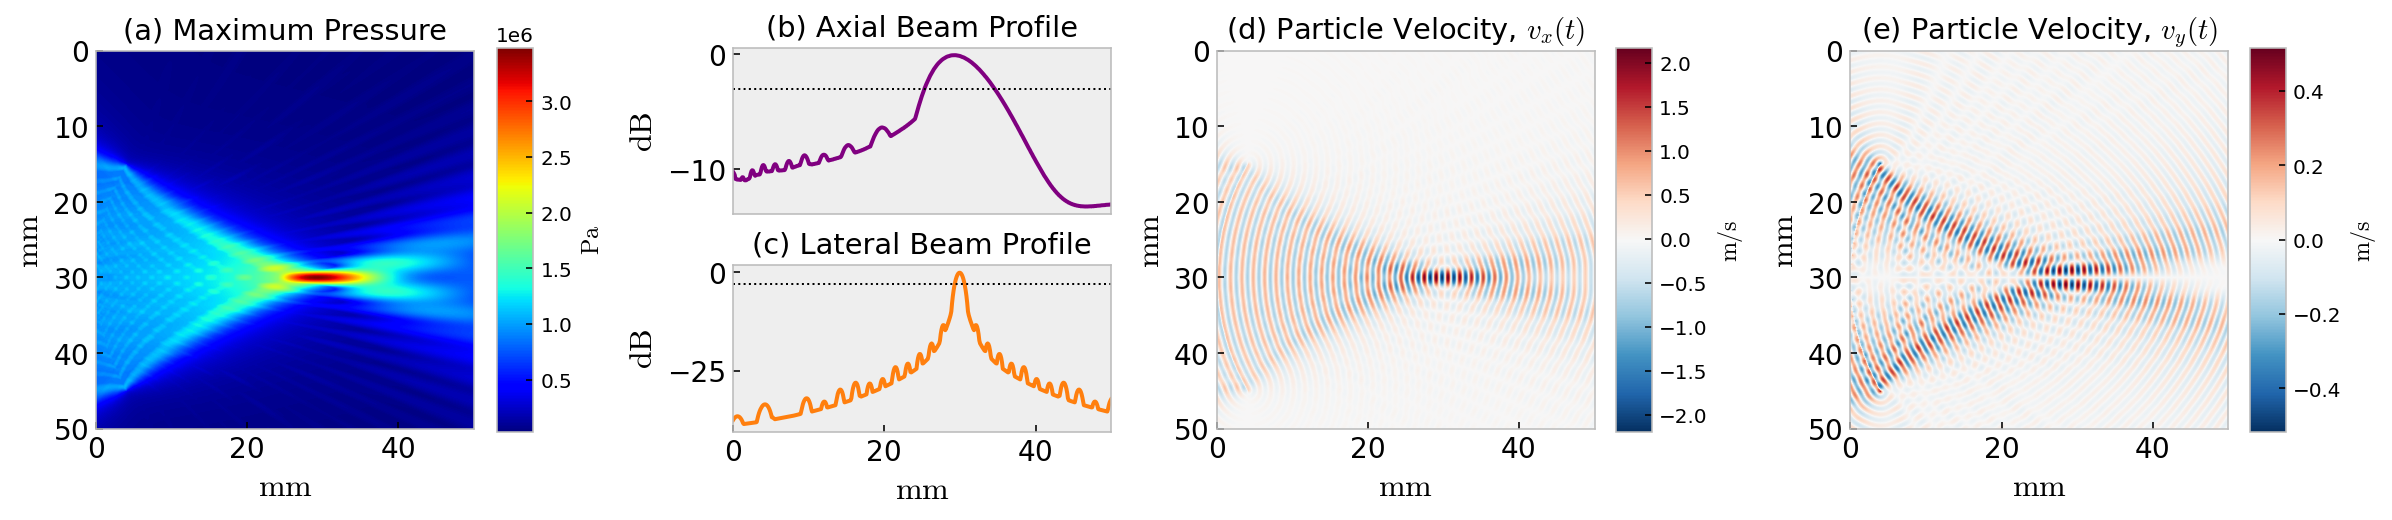

In [9]:
# group the single transducer fields into one list 
single_trxd_fields = [single_trxd.max_pressure, single_trxd.dB_intensity(), 
                      single_trxd.vx[Nt-1], single_trxd.vy[Nt-1]]

# heatmap extent
extent = (0, Nx * dx * 1e3, Ny * dy * 1e3, 0)

# plot the fields                       
plot_single_trxd_fields(max_pressure=single_trxd_fields[0], 
                        dB_intensity=single_trxd_fields[1], 
                        vx=single_trxd_fields[2], vy=single_trxd_fields[3],
                        x=x, fr=fr, dx=dx,
                        extent=extent,
                        figure_path=None)

In [10]:
print(f'single transducer gain factor: {np.max(single_trxd.max_pressure) * 1e-6}')

single transducer gain factor: 3.481438


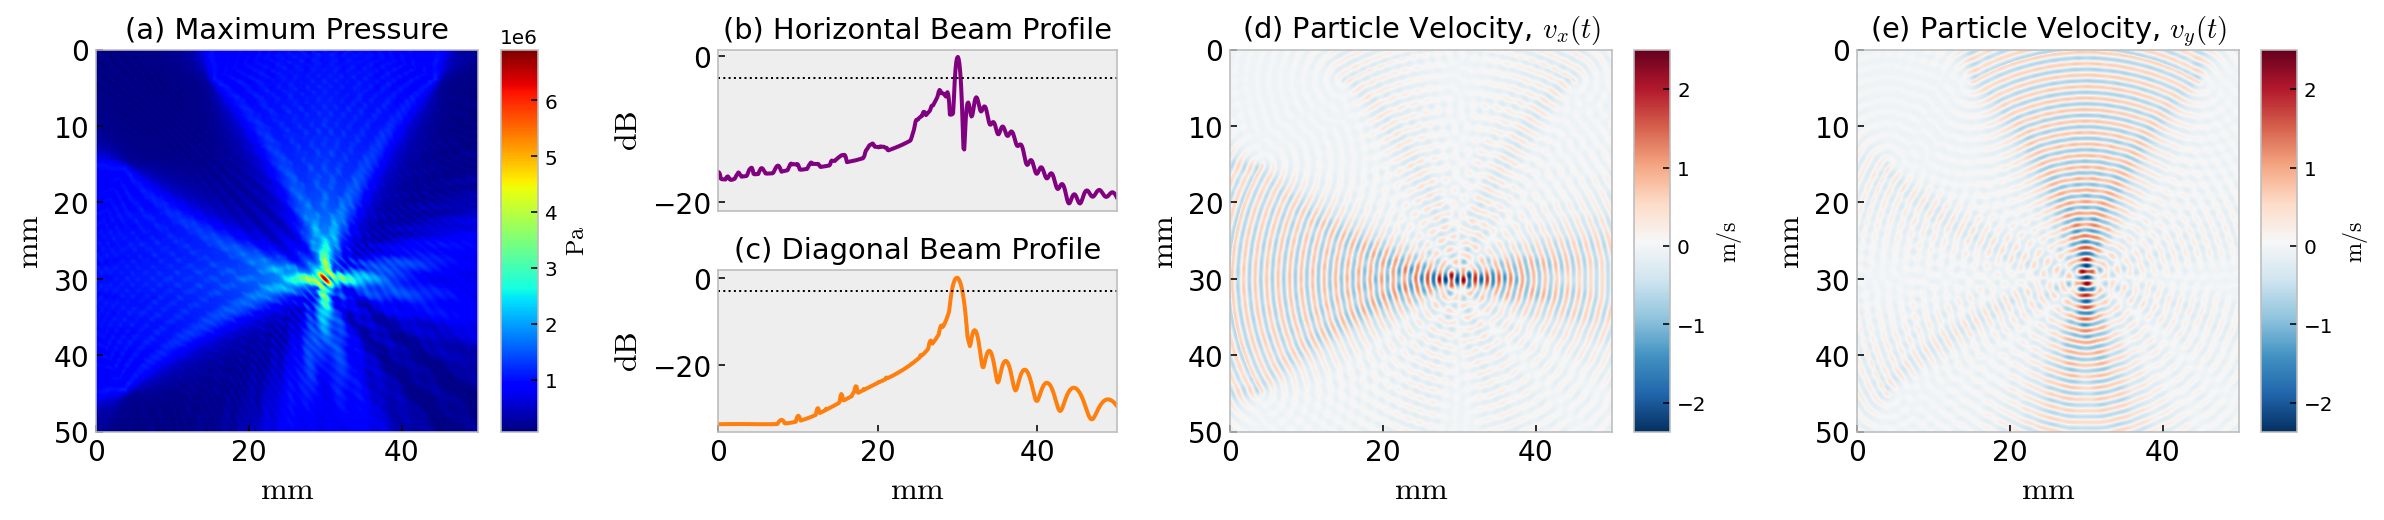

In [11]:
# group the orthogonal transducers fields into one list 
orthogonal_trxd_fields = [orthogonal_trxd.max_pressure, 
                          orthogonal_trxd.dB_intensity(), 
                      orthogonal_trxd.vx[Nt-1], orthogonal_trxd.vy[Nt-1]]
# heatmap extent
extent = (0, Nx * dx * 1e3, Ny * dy * 1e3, 0)

# plot the fields 
plot_orthogonal_trxd_fields(max_pressure=orthogonal_trxd_fields[0], 
                            dB_intensity=orthogonal_trxd_fields[1],
                            vx=orthogonal_trxd_fields[2], vy=orthogonal_trxd_fields[3],
                            x=x, fr=fr, dx=dx,
                            extent=extent,
                            figure_path=None)

In [12]:
print(f'orthogonal transducer gain factor: {np.max(orthogonal_trxd.max_pressure) * 1e-6 / 2}')

orthogonal transducer gain factor: 3.454513


As we will see in the next section, ARF formula requires temporal averaging over one complete cycle of the wave (wave period). Therefore, we need to know how many simulation time steps it takes for one complete cycle. 

Recall that period is the inverse of frequency: $T = \frac{1}{f}$. Therefore, 

$$T = \frac{1}{1\times 10^6\ Hz}=1\times 10^{-6}\ s$$

Our temporal resolution $dt$ is 20 nano seconds. The number of simulation time steps it takes for one complete cycle is:

$$N_T = \frac{1\times 10^{-6}\ s}{20 \times 10^{-9}\ s}=50$$

# 2.&nbsp;Acoustic Radiation Force (ARF)

## General Second-Order Approximation for ARF

The most general form of acoustic radiation force computed for an inviscid, lossless fluid is

\begin{equation}\tag{1}
\mathbf{F} = \int\int_S \bigg[-\frac{1}{2\rho_0 c_0^2}\langle p^2 \rangle   \mathbf{n} + \frac{1}{2}\rho_0\langle  |\mathbf{v}|^2 \rangle\mathbf{n} - \rho_0\langle\mathbf{v}(\mathbf{v.n})\rangle \bigg]dS
\end{equation}

Which is the force on a volume enclosed by surface $S$, with a unit vector $n$ that is normal to $S$. 

$\langle p_E\rangle = \langle p-p_0\rangle = \frac{1}{2\rho_0 c_0^2}\langle p^2 \rangle - \frac{1}{2}\rho_0\langle  |\mathbf{v}|^2 \rangle$ is the mean Eulerian excess pressure. Putting it all together, we can write the formula in a simpler fashion:

\begin{equation}\tag{2}
F_i = -\frac{\partial \langle p_E\rangle}{\partial x_i} - \rho_0 \frac{\partial \langle v_iv_k\rangle}{\partial x_k}
\end{equation}

and more compactly, in vector notation:

\begin{equation}\tag{3}
\mathbf{F} = -\nabla\langle p_E \rangle  -\rho_0 \langle \mathbf{v(\nabla.\mathbf{v})} + (\mathbf{v}.\nabla)\mathbf{v}) \rangle
\end{equation}


Note that since $\langle \cdot \rangle$ denotes temporal average while the differentiation is over space (gradient), one could swap the orders and first take the gradient and then apply temporal average. 

Often times, especially in the case of quasi-planar waves and purely planar waves, multiple levels of approximation can be made which greatly simplify equation 2. We will be looking at this problem in the following order: 

1. Complete form: Using Eq. (2) and/or (3) without any simplifying assumptions. 
2. Quasi-planar wave assumption: setting the mean Eulerian excess pressure to zero.
3. Purely planar wave assumption: setting all cross gradients to zero, $\frac{\partial v_i}{\partial x_j}\delta_{ij} $


In each section we will explain the reasoning behind each of these simplifying assumptions and in the end we will be comparing them against the complete form. In the first half of the notebook we will look at the case of a single transducer. Then, we will essentially repeat the steps for the orthogonal transducers and discuss the advantages of one regime versus the other. 

## 2.1. Single Transducer


### Complete form 

To compute ARF, we need to compute gradients as well as temporal averages by means of numerical differentiation and integration, respectively. Python has libraries that will help us with that. However, since the temporal average requires a scaling factor outside the integral, we need to write a function that computes it for us.

Recall the formula for average value of a function:

\begin{equation}\tag{4}
\overline{g(x)} = \frac{1}{t_2-t_1}\int_{t_1}^{t_2} g(x, t) dt
\end{equation}

In [13]:
def temporal_ave(array, t1, t2, dt):
  ''' 
  computes the temporal average over specified time domain

  Input Params
  -------------
  array: input 3D array. First axis is time (axis=0)
  t1: first time step 
  t2: second time step that is one period away from t1
  dt: temporal resolution. It is 20 ns in our k-wave simulations

  Output
  -------
  temporal average, a 2D array (time is averaged out)
  '''
  return (1 / ((t2 - t1))) * np.trapz(array, dx=dt, axis=0)

In [14]:
N_T = 50
t1 = 2300
# for numerical stability at the edges, we add an extra 1 to N_T
t2 = 2300 + N_T + 1

Now we will have to expand Eq. (2) and write it out explicitly so we can implement it in code. We will do this step by step:

\begin{equation}
\langle p_E\rangle = \frac{1}{2\rho c^2}\langle p^2\rangle - \frac{1}{2}\rho \langle v_x^2 + v_y^2\rangle
\end{equation}

\begin{equation}\tag{5}
\nabla \langle p_E\rangle=
\begin{pmatrix}
\frac{\partial}{\partial x} \big[ \frac{1}{2\rho c^2}\langle p^2\rangle - \frac{1}{2}\rho \langle v_x^2 + v_y^2\rangle \big]\\
\frac{\partial}{\partial y} \big[ \frac{1}{2\rho c^2}\langle p^2\rangle - \frac{1}{2}\rho \langle v_x^2 + v_y^2\rangle \big]\\
\end{pmatrix}\enspace \in \mathbb{R}^2
\end{equation}


We will break up the gradient/divergence component into two parts: 

\begin{equation}
\nabla.v = \bigg(\frac{\partial}{\partial x}, \frac{\partial}{\partial y} \bigg)
\begin{pmatrix}
v_x \\
v_y
\end{pmatrix} = \frac{\partial v_x}{\partial x} + \frac{\partial v_y}{\partial y}\enspace \in \mathbb{R}
\end{equation}


\begin{equation}\tag{6}
(\nabla.v)v = \bigg(\frac{\partial v_x}{\partial x} + \frac{\partial v_y}{\partial y}\bigg)
\begin{pmatrix}
v_x \\
v_y
\end{pmatrix} = 
\begin{pmatrix}
v_x\frac{\partial v_x}{\partial x} + v_x\frac{\partial v_y}{\partial y} \\
v_y\frac{\partial v_x}{\partial x} + v_y\frac{\partial v_y}{\partial y}
\end{pmatrix}\enspace \in \mathbb{R}^2
\end{equation}

---
\begin{equation}
v.\nabla = \bigg(v_x, v_y \bigg)
\begin{pmatrix}
\frac{\partial}{\partial x} \\
\frac{\partial}{\partial y}
\end{pmatrix}=
v_x\frac{\partial }{\partial x} + v_y\frac{\partial }{\partial y}\enspace \in \mathbb{R}
\end{equation}

\begin{equation}\tag{7}
(v.\nabla)v = \bigg(v_x\frac{\partial}{\partial x} + v_y\frac{\partial}{\partial y}\bigg)
\begin{pmatrix}
v_x \\
v_y
\end{pmatrix} = 
\begin{pmatrix}
v_x\frac{\partial v_x}{\partial x} + v_y\frac{\partial v_x}{\partial y} \\
v_x\frac{\partial v_y}{\partial x} + v_y\frac{\partial v_y}{\partial y}
\end{pmatrix}\enspace \in \mathbb{R}^2
\end{equation}

Puttinng Eq. (6) and (7) together, and applying a temporal average we have:

\begin{equation}
\rho \Bigg\langle 
\begin{matrix}
2v_x\frac{\partial v_x}{\partial x} + v_X\frac{\partial v_y}{\partial y} + v_y\frac{\partial v_x}{\partial y}  \\
2v_y\frac{\partial v_y}{\partial y} + v_y\frac{\partial v_x}{\partial x} + v_x\frac{\partial v_y}{\partial x}
\end{matrix}
\Bigg\rangle
\end{equation}



And finally putting it all together with Eq. (5) we have the following for ARF:

\begin{equation}\tag{8}
\mathbf{F} = - 
\begin{pmatrix}
\frac{\partial}{\partial x} \big[ \frac{1}{2\rho c^2}\langle p^2\rangle - \frac{1}{2}\rho \langle v_x^2 + v_y^2\rangle \big] + \rho \big\langle 2v_x\frac{\partial v_x}{\partial x} + v_x\frac{\partial v_y}{\partial y} + v_y\frac{\partial v_x}{\partial y}\big\rangle \\ 
\frac{\partial}{\partial y} \big[ \frac{1}{2\rho c^2}\langle p^2\rangle - \frac{1}{2}\rho \langle v_x^2 + v_y^2\rangle \big] + \rho \big\langle 2v_y\frac{\partial v_y}{\partial y} + v_y\frac{\partial v_x}{\partial x} + v_x\frac{\partial v_y}{\partial x} \big \rangle
\end{pmatrix} \enspace \in \mathbb{R}^2
\end{equation}



Each row corresponds to a component of the force vector $\mathbf{F}$. Since our simulations are all in 2D, $\mathbf{F}\in \mathbb{R}^2$.

To make our job easier, we will define a class that computes the gradients for each of the velocity components along the two axes. 

In [15]:
# define a new class that computes the gradients along x and y
class Gradients:
    def __init__(self, vx, vy):
        self.dvxdx = np.gradient(vx[t1:t2, :, :], dx, axis=2)
        self.dvxdy = np.gradient(vx[t1:t2, :, :], dx, axis=1)
        self.dvydx = np.gradient(vy[t1:t2, :, :], dx, axis=2)
        self.dvydy = np.gradient(vy[t1:t2, :, :], dx, axis=1)

In [16]:
single_trxd_grad = Gradients(single_trxd.vx, single_trxd.vy)
orthogonal_trxd_grad = Gradients(orthogonal_trxd.vx, orthogonal_trxd.vy)

In [17]:
# dimensions of a sample derivative. Notice how there are n-2 rows and columns
print(f'dvx/dx shape: {single_trxd_grad.dvxdx.shape}')

dvx/dx shape: (51, 500, 500)


Now that we have the gradients computed, we will go ahead and plot a few of them just to make sure we have done it right. You should observe that wherever the slope of the velocity is positive, the gradient has a positive value, and wherever the slope of the velocity trace is negative, the gradient itself has a negative value in that range. 

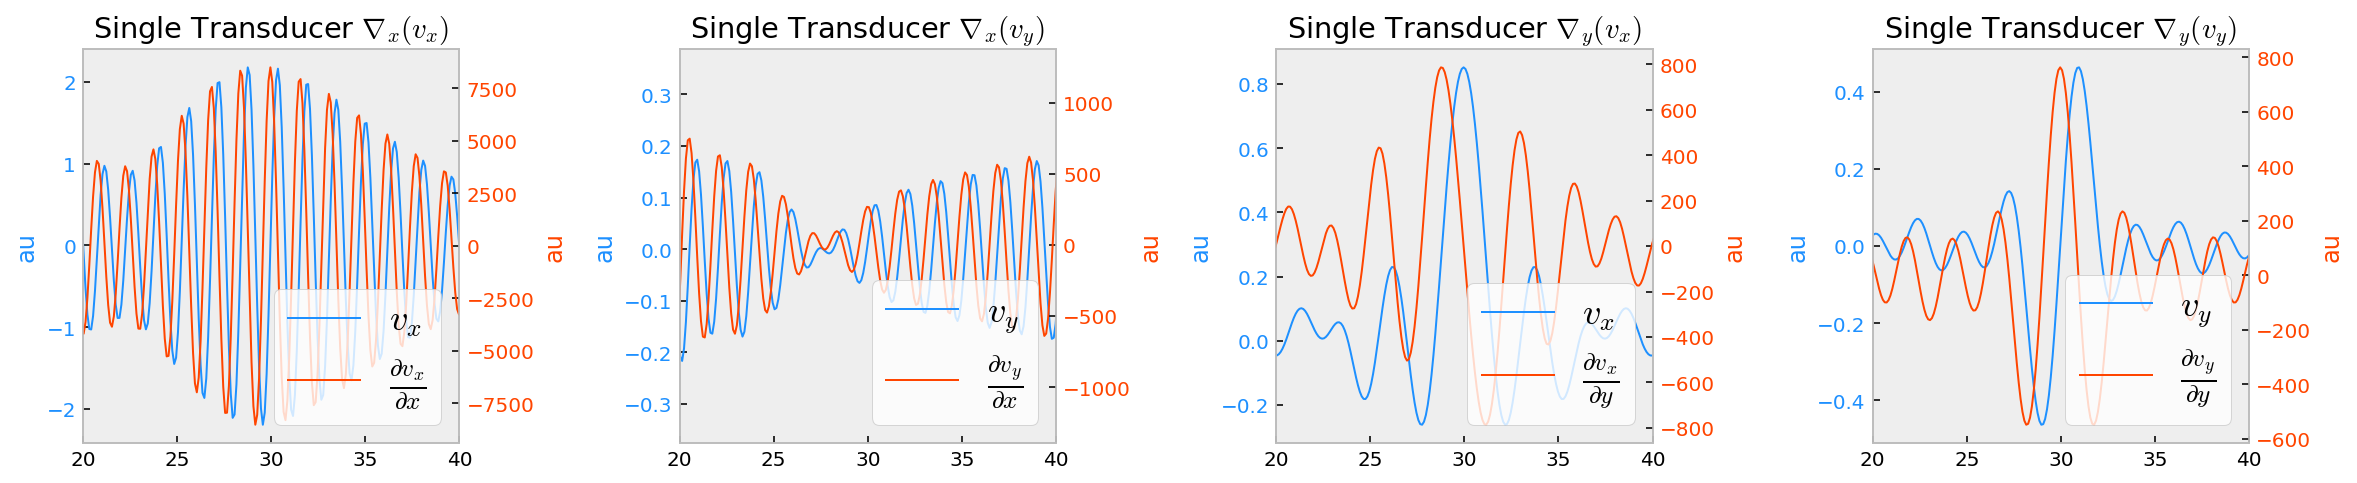

In [18]:
# plot the gradients for the single transducer 
plot_single_trxd_gradients(single_trxd.vx, single_trxd.vy, 
                           single_trxd_grad.dvxdx, single_trxd_grad.dvydx,
                           single_trxd_grad.dvxdy, single_trxd_grad.dvydy,
                           x, fr, dx, t1,
                           figure_path=None)

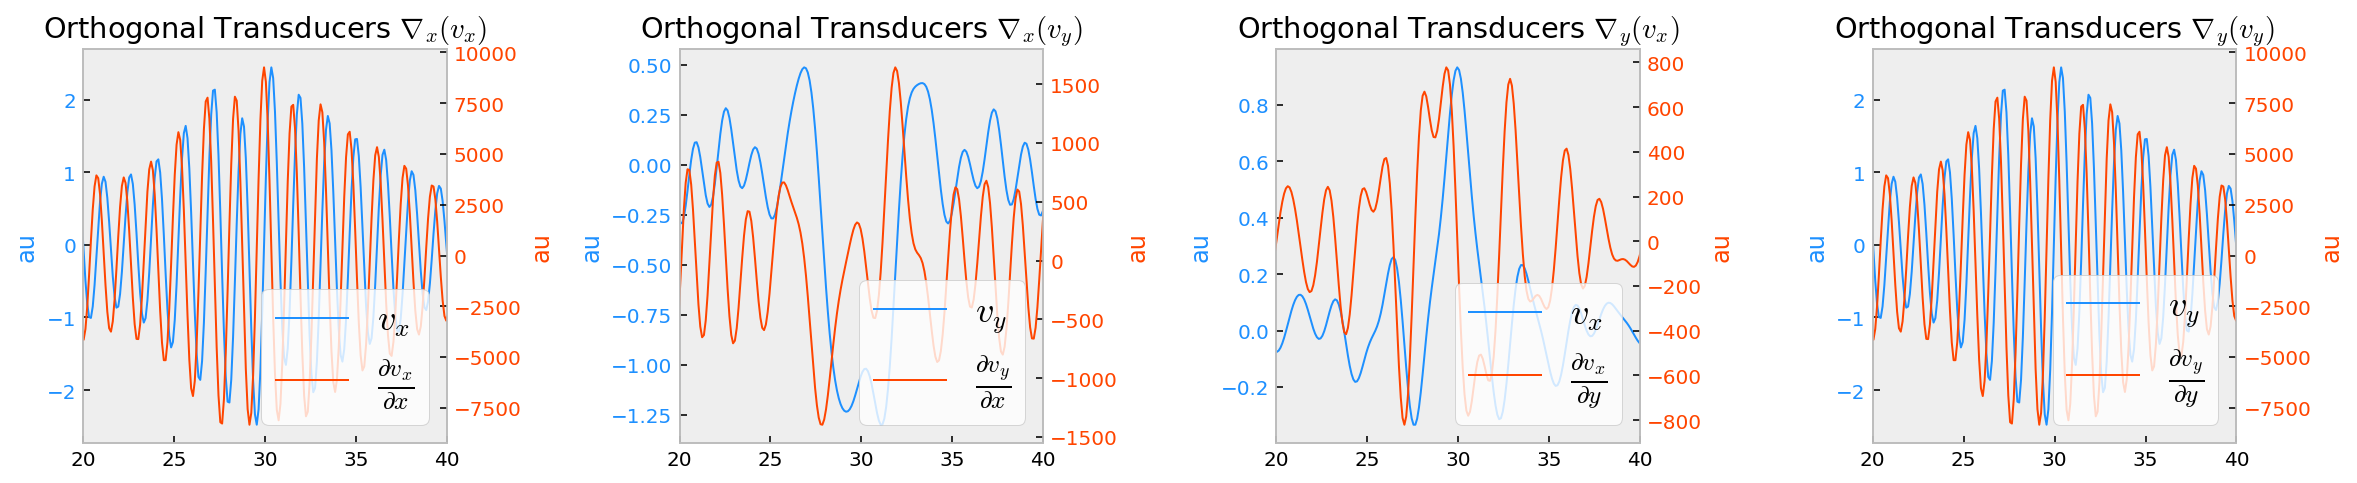

In [19]:
# plot the gradients for the orthogonal transducers 
plot_orthogonal_trxd_gradients(orthogonal_trxd.vx, orthogonal_trxd.vy, 
                           orthogonal_trxd_grad.dvxdx, orthogonal_trxd_grad.dvydx,
                           orthogonal_trxd_grad.dvxdy, orthogonal_trxd_grad.dvydy,
                           x, fr, dx, t1, 
                           figure_path=None)

### Mean Eulerian Excess Pressure
Now that we have done the math and we have all the gradients and functions we need, we will compute ARF. We will start by computing $\langle p_E \rangle$.

In [20]:
# extract the pressure 
p_single = single_trxd.pressure

In [21]:
# compute the first term in pE:
# time averaged pressure squared
p2_temporal_ave = temporal_ave(np.power(p_single[t1:t2, :, :], 2),
                               t1, t2, dt=dt)

# compute the second term in pE: 
pE1 = 1 / (2 * rho * c ** 2) * p2_temporal_ave

# compute the second term in pE: 
v_norm_sqrd = (np.power(single_trxd.vx[t1:t2, :, :], 2) + 
               np.power(single_trxd.vy[t1:t2, :, :], 2))
pE2 = 1 / 2 * rho * temporal_ave(v_norm_sqrd, t1, t2, dt=dt)

# compute <pE> = pE1 - pE2
pE = pE1 - pE2

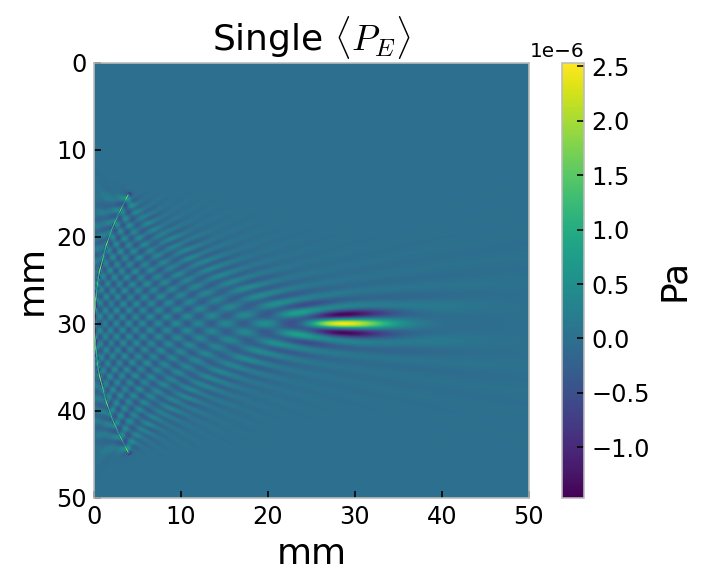

In [22]:
plt.imshow(pE, extent=[0, 50, 50, 0])
plt.title(r'Single $\langle P_E \rangle$', fontsize=18)
cbar = plt.colorbar()
cbar.set_label('Pa', fontsize=18)
cbar.ax.tick_params(labelsize=12)

plt.grid(False)
plt.xlabel('mm', fontsize=18)
plt.xticks(fontsize=12)
plt.ylabel('mm', fontsize=18)
plt.yticks(fontsize=12)

#plt.savefig(figure_path + 'pE_single', dpi=600)
plt.show()

In [23]:
# print the gradient values
dpEdx = np.gradient(pE, dx, axis=1)
dpEdy = np.gradient(pE, dx, axis=0)

print(f'maximum dpEdx: {np.max(dpEdx)}, maximum dpEdy: {np.max(dpEdy)}')

maximum dpEdx: 0.033010490238666534, maximum dpEdy: 0.014021274633705616


In [24]:
col = 100 # columns after the transducer, and before the end of the simulation grid
# if we don't clip the ends, gradients on the edges blow up, given the sharp concatenation of the simulations.

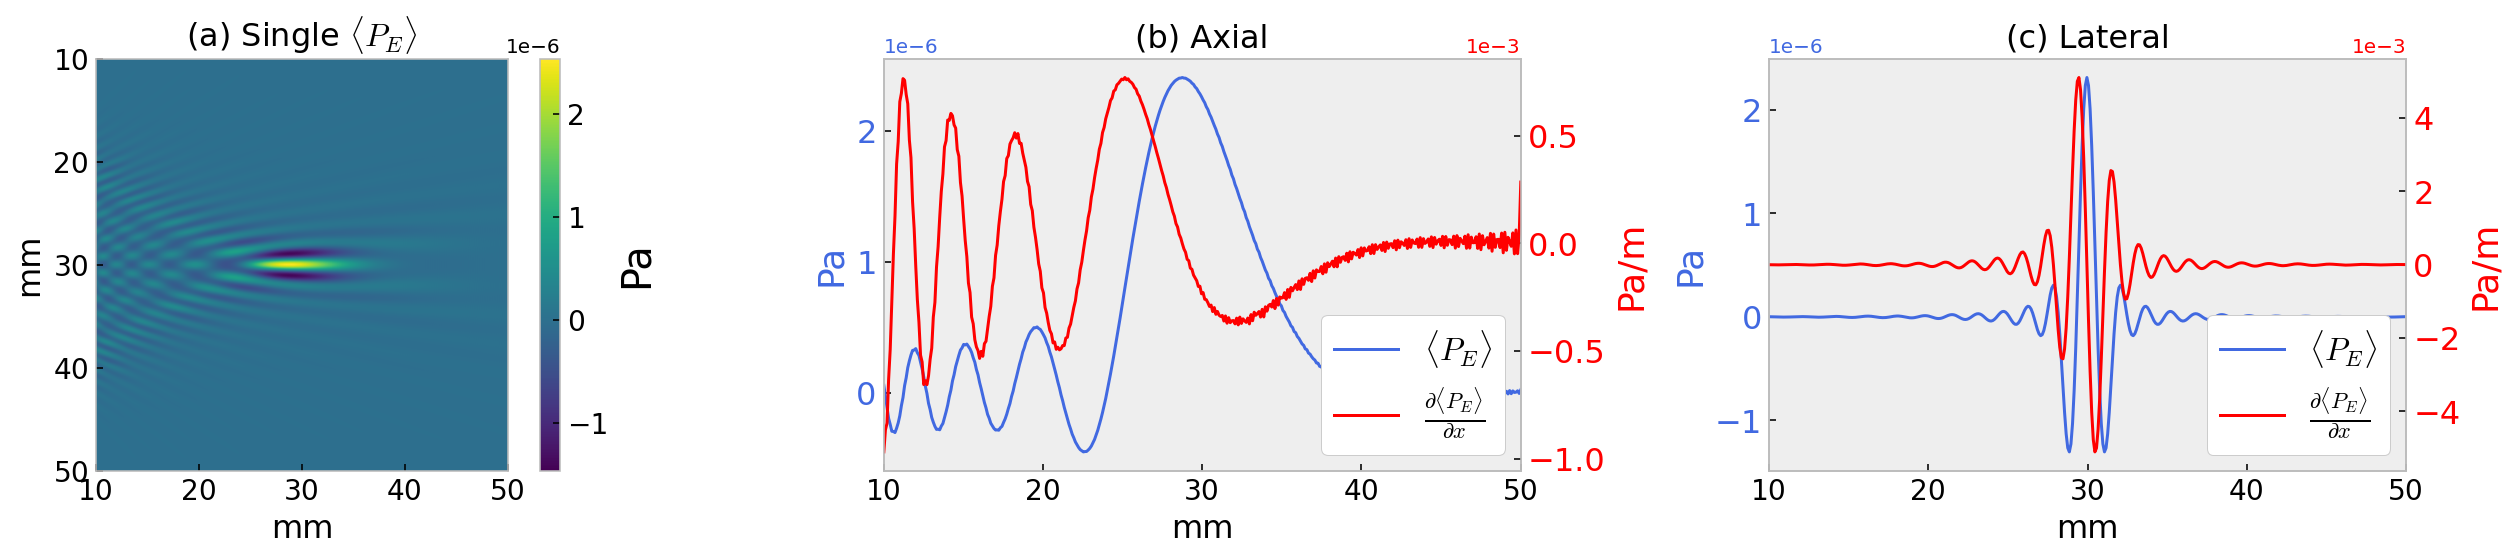

In [25]:
plot_Mean_Eulerian_Pressure(pE, x, dx, fr, dpEdx, dpEdy, col, figure_path=None)

now we will compute $F_x$ and $F_y$, using the general ARF formula, equation (3).

In [26]:
# slice vx and vy such that they have the same number of Nt as their gradients 
# we computed earlier, so that we can carry out elementwise multiplication
single_trxd_vx = single_trxd.vx[t1:t2, :, :]
single_trxd_vy = single_trxd.vy[t1:t2, :, :]
single_trxd_dvxdx = single_trxd_grad.dvxdx
single_trxd_dvxdy = single_trxd_grad.dvxdy
single_trxd_dvydx = single_trxd_grad.dvydx
single_trxd_dvydy = single_trxd_grad.dvydy

**-1 scaling factor:** 

a very important point is that when you compute the gradients along the $y$-axis, since array indexing starts from the top row going down, positive $\nabla_y$ will in fact point downwards, while $-\nabla_y$ will point upwards. In order to bring the force signs back to conventional $\text{up}/\text{down}=+/-$, we will have to multiply $F_y$ by $-1$. This problem is not present when computing $\nabla_x$, since the conventional $\text{left}/\text{right}=-/+$ matches the indexing of arrays, where indexing starts from the left.


In [27]:
# <v(del. v) + (v.del)v>
single_trxd_vdelv_x = temporal_ave((2 * single_trxd_vx * single_trxd_dvxdx + 
                                    single_trxd_vx * single_trxd_dvydy + 
                                    single_trxd_vy * single_trxd_dvxdy), 
                                   t1, t2, dt)
single_trxd_vdelv_y = temporal_ave((2 * single_trxd_vy * single_trxd_dvydy + 
                                    single_trxd_vy * single_trxd_dvxdx + 
                                    single_trxd_vx * single_trxd_dvydx), 
                                   t1, t2, dt)

Fx_single = - (dpEdx + rho * single_trxd_vdelv_x)
Fy_single = - (dpEdy + rho * single_trxd_vdelv_y)
# apply the -1 correction 
Fy_single = - Fy_single

# set maximum and minimum for F away from transducer surface.
Fx_single_max = np.max(Fx_single[:, col:-col])
Fx_single_min = - Fx_single_max

# save Fy max for later comparison 
Fy_single_max = np.max(Fy_single[:, col:-col])
Fy_single_min = - Fy_single_max

It is time to see what the on-axis force profile, $F_x$ looks like. You will notice there are some ripples in the field that suggest aliasing. Aliasing and Gibbs ringing are known artifacts of pseudospectral method if collocated grids are used.$^3$

In order to smooth out the field we will apply a Gaussian filter with $\sigma = 0.9$. This a heuristic choice. You can vary the value of $\sigma$ and see for yourself that values lower than $0.9$ still fit the noise. And you don't want to increase $\sigma$ too much to lose information. 


In [28]:
# apply Gaussian filters to both Fx and Fy
filtered_Fx_single = sp.ndimage.gaussian_filter(Fx_single, sigma=0.9)
filtered_Fy_single = sp.ndimage.gaussian_filter(Fy_single, sigma=0.9)

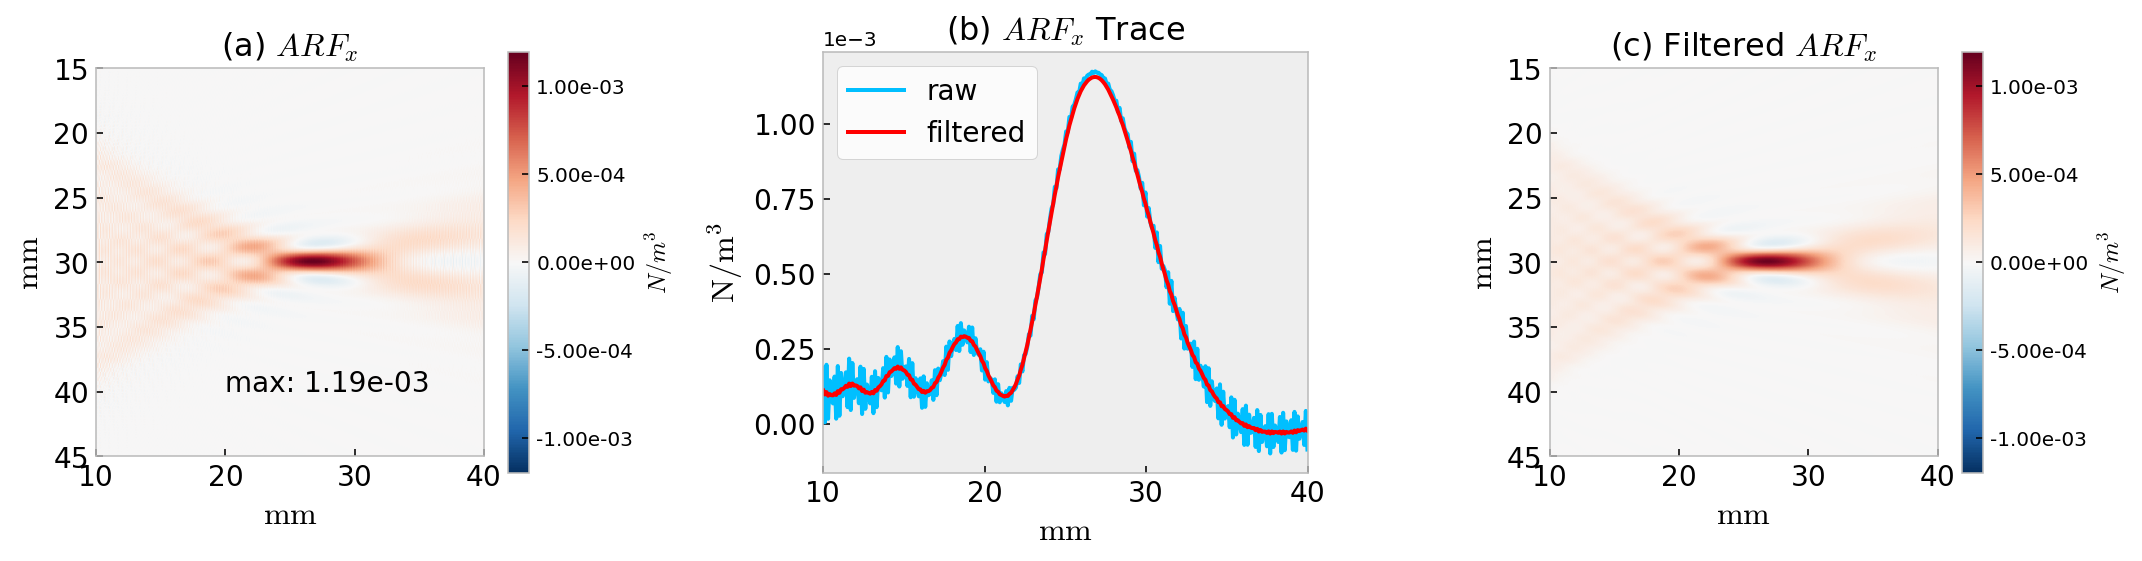

In [29]:
# plot single transducer ARF along the x-axis 
plot_single_trxd_ARFx(Fx_single, filtered_Fx_single, Fx_single_min, 
                      Fx_single_max, text_loc=[20, 40], col=col,
                      x=x, dx=dx, Nx=Nx, dy=dy, Ny=Ny, fr=fr,
                      file_name='single_trxd_ARFx', figure_path=None)

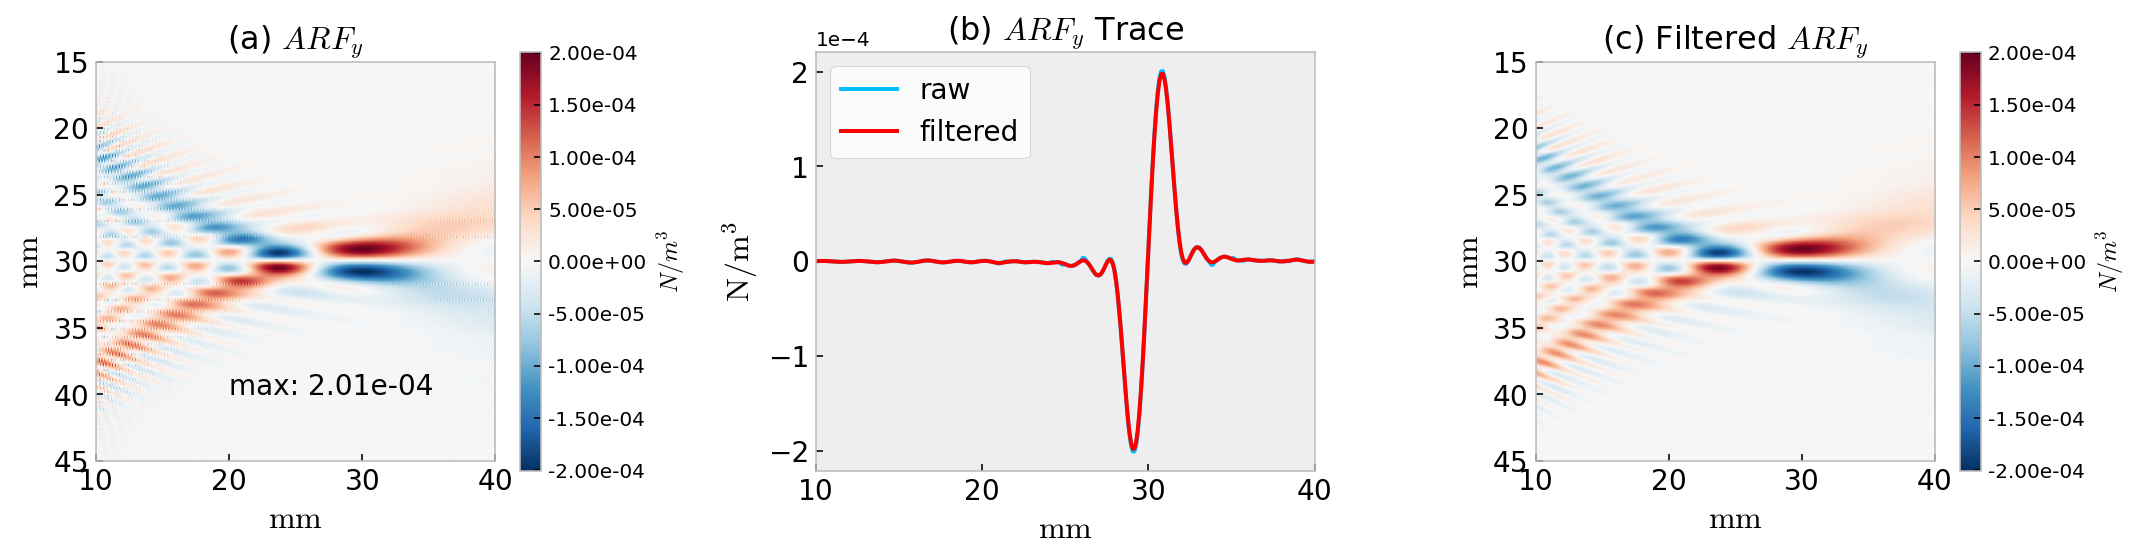

In [30]:
# plot single transducer ARF along the y-axis 
plot_single_trxd_ARFy(Fy_single, filtered_Fy_single, Fy_single_min, 
                      Fy_single_max, text_loc=[20, 40], col=col,
                      x=x, dx=dx, Nx=Nx, dy=dy, Ny=Ny, fr=fr,
                      file_name='single_trxd_ARFy', figure_path=None)

The two plots above, $ARF_x$ and $ARF_y$ do a good job of showing the magnitude of the force for any given direction over the entirety of the field. However, since we are dealing with vectors $\mathbf{F}$, it will be useful to be able to superimpose the actual force vectors on the pressure field. That way we can show for any given point in space its maximum pressure as well as the magnitude and direction of the corresponding acoustic radiation force, $\mathbf{F}$. Quiver plots are useful visualization aids we can use for that purpose. 

In [31]:
# define the x and y positions. They both span an axis of lenght 500
x_pos = np.linspace(0, 50, Nx)
y_pos = np.linspace(0, 50, Ny)

# set a quiver resolution, qres. If you choose a very small number, it will be 
# very hard to see anything due to crowdedness of all the force vectors. A good 
# number seems to be something between 10 and 20. I chose 15
qres = 15 
# define a meshgrid over those x and y positions. I am choosing a finer mesh in 
# y, so that we can see mroe force vectors along the y-axis. 
X, Y = np.meshgrid(x_pos[col:-col:qres], y_pos[::int(qres/3)])

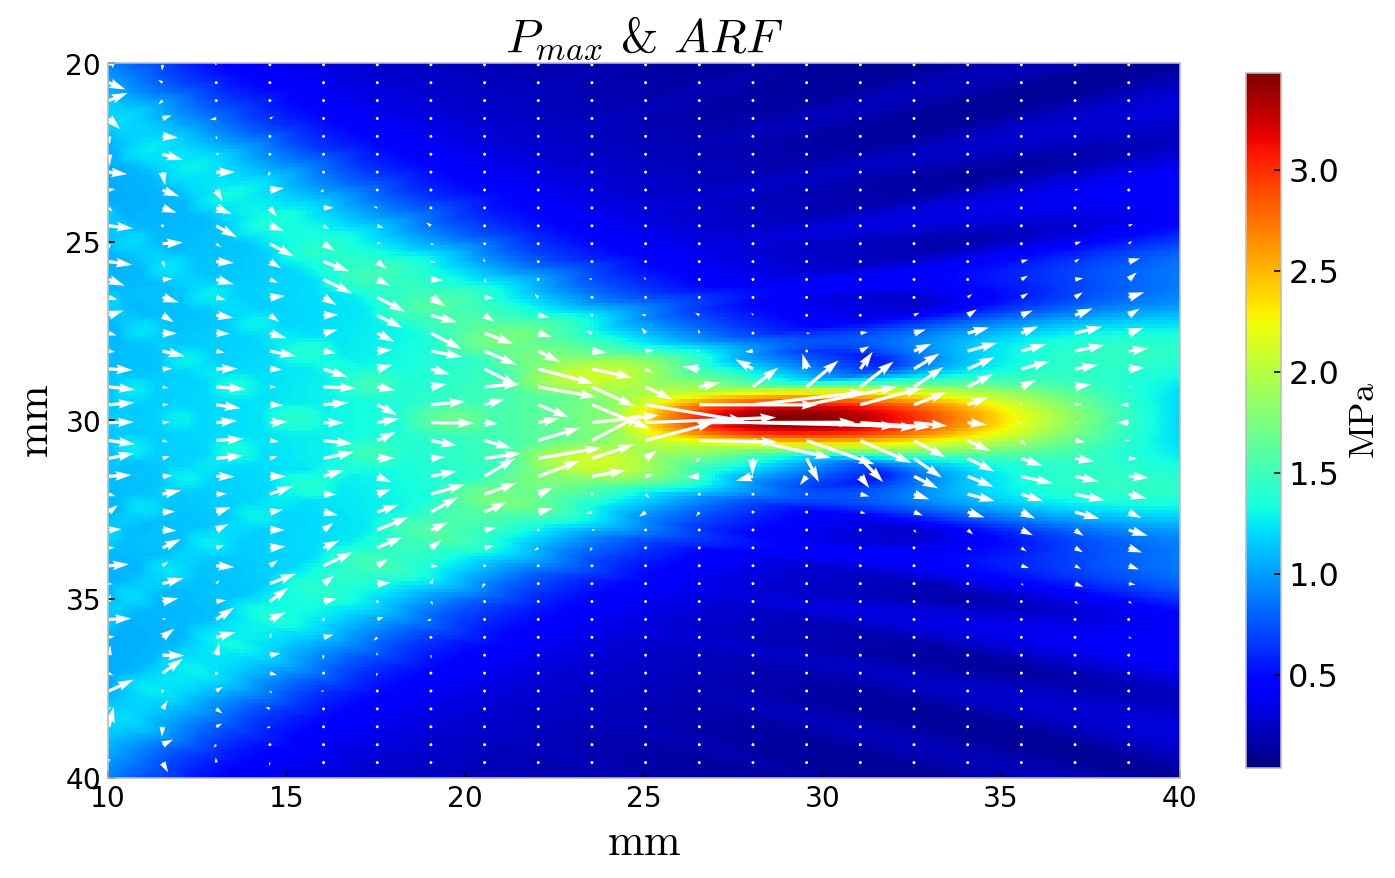

In [32]:
# plot single transducer max pressure along with ARF
plot_single_trxd_ARF_quiver(single_trxd.max_pressure, Fx_single, Fy_single, 
                            file_name='single_Pmax_ARF', scale=8e-3, col=col,
                            dx=dx, Nx=Nx, dy=dy, Ny=Ny, X=X, Y=Y, qres=qres,
                            figure_path=None)

### Quasi-plane wave approximation 
In general, the mean Eulerian excess pressure $\langle p_E\rangle$ is not zero. However, in the case of wide quasi-planar waves, $p=\rho_0c_ov$, and therefore, $\langle p_E\rangle = \frac{1}{2\rho_0 c_0^2}\langle p^2 \rangle - \frac{1}{2}\rho_0\langle  |\mathbf{v}|^2 \rangle = 0$. In this case, we can simplify equation (2):

\begin{equation}\tag{9}
F_i = - \rho_0 \frac{\partial \langle v_iv_k\rangle}{\partial x_k}
\end{equation}

and in vector notation

\begin{equation}\tag{10}
\mathbf{F} = -\rho_0 \langle \mathbf{v(\nabla.\mathbf{v})} + (\mathbf{v}.\nabla)\mathbf{v}) \rangle
\end{equation}


The only thing we need to change from the previous section is our definition of ARF. We will remove ``dpEdx`` and ``dpEdy`` from ``Fx`` and ``Fy``. ``Fx_max`` and ``Fx_min`` will also be redefined accordingly. We can simply use our code from above to complete the plots. 

In [33]:
Fx_single_quasi = - rho * single_trxd_vdelv_x
Fy_single_quasi = - rho * single_trxd_vdelv_y
# apply the -1 correction 
Fy_single_quasi = - Fy_single_quasi

# set maximum and minimum for F away from transducer surface 
Fx_max_single_quasi = np.max(Fx_single_quasi[:, col:-col])
Fx_min_single_quasi = - Fx_max_single_quasi

Fy_max_single_quasi = np.max(Fy_single_quasi[:, col:-col])
Fy_min_single_quasi = - Fy_max_single_quasi

# apply Gaussian filters to both Fx and Fy
filtered_Fx_single_quasi = sp.ndimage.gaussian_filter(Fx_single_quasi, sigma=0.9)
filtered_Fy_single_quasi = sp.ndimage.gaussian_filter(Fy_single_quasi, sigma=0.9)

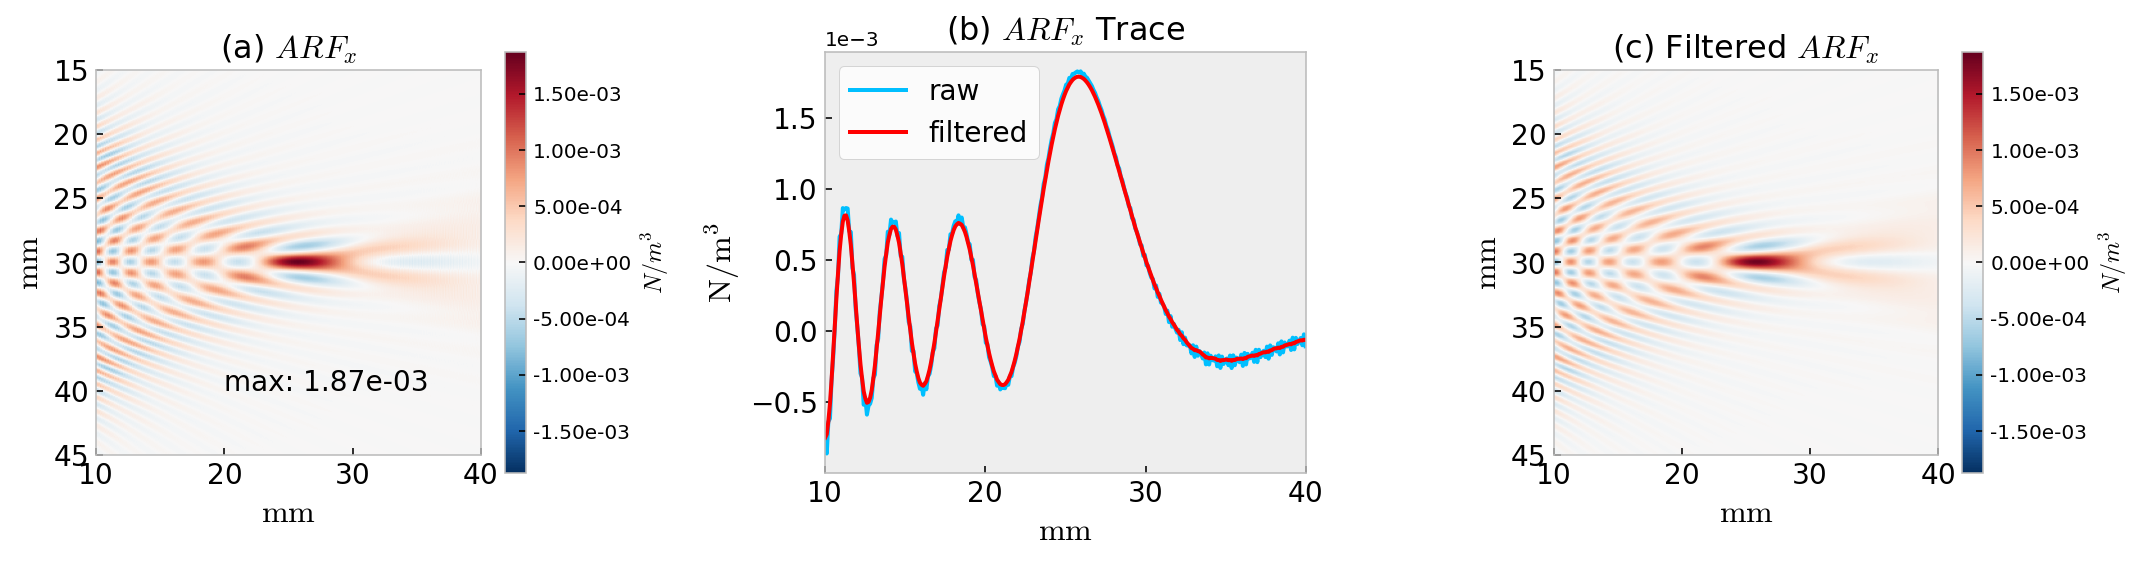

In [34]:
# plot single transducer quasi-planar ARF along the x-axis 
plot_single_trxd_ARFx(Fx=Fx_single_quasi, filtered_Fx=filtered_Fx_single_quasi, 
                      min_=Fx_min_single_quasi, max_=Fx_max_single_quasi, 
                      text_loc=[20, 40], col=col,
                      x=x, dx=dx, Nx=Nx, dy=dy, Ny=Ny, fr=fr,
                      file_name='single_trxd_QP_ARFx', figure_path=None)

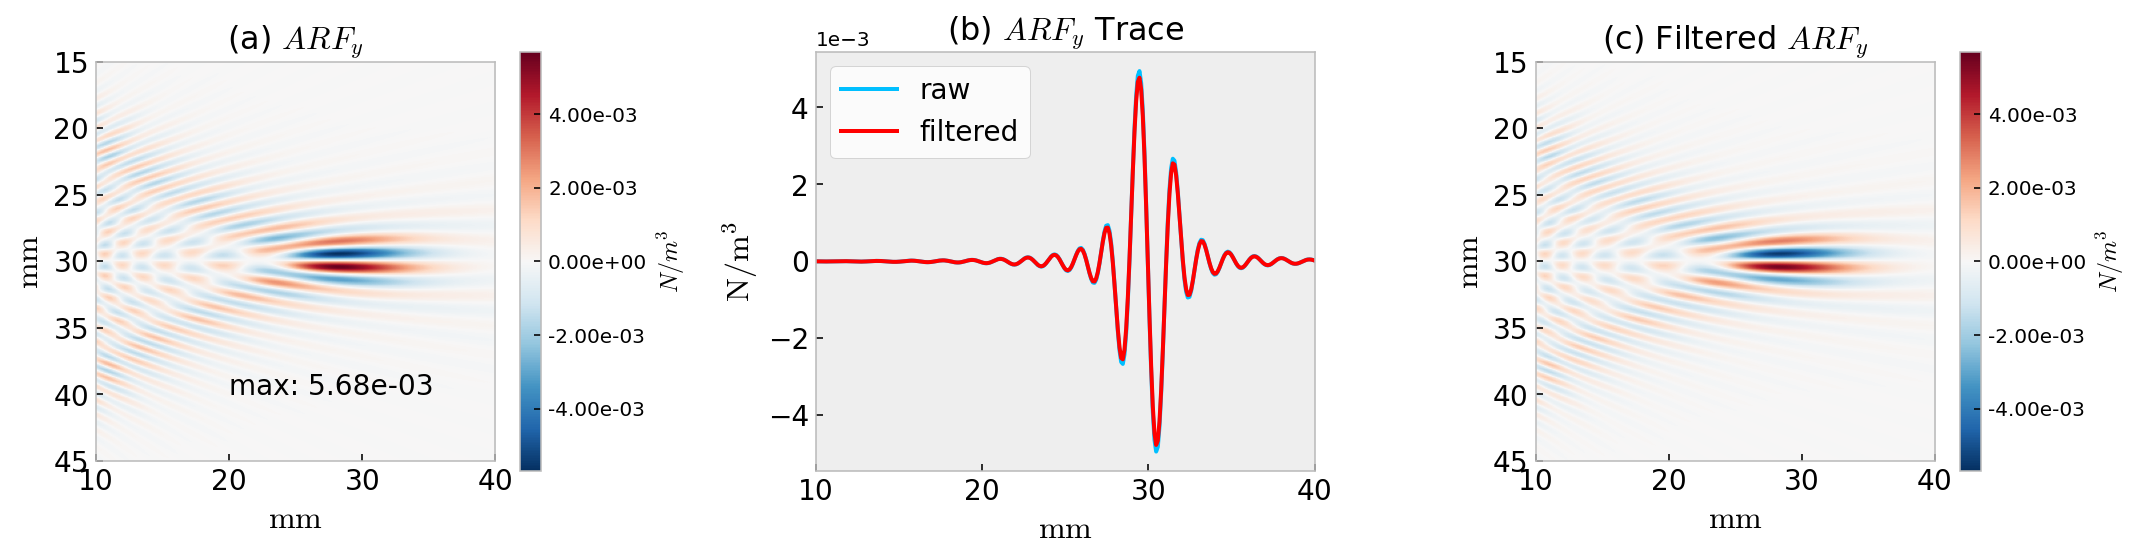

In [35]:
# plot single transducer quasi-planar ARF along the y-axis 
plot_single_trxd_ARFy(Fy_single_quasi, filtered_Fy_single_quasi, 
                      Fy_min_single_quasi, Fy_max_single_quasi, 
                      text_loc=[20, 40], col=col,
                      x=x, dx=dx, Nx=Nx, dy=dy, Ny=Ny, fr=fr,
                      file_name='single_trxd_QP_ARFy', figure_path=None)

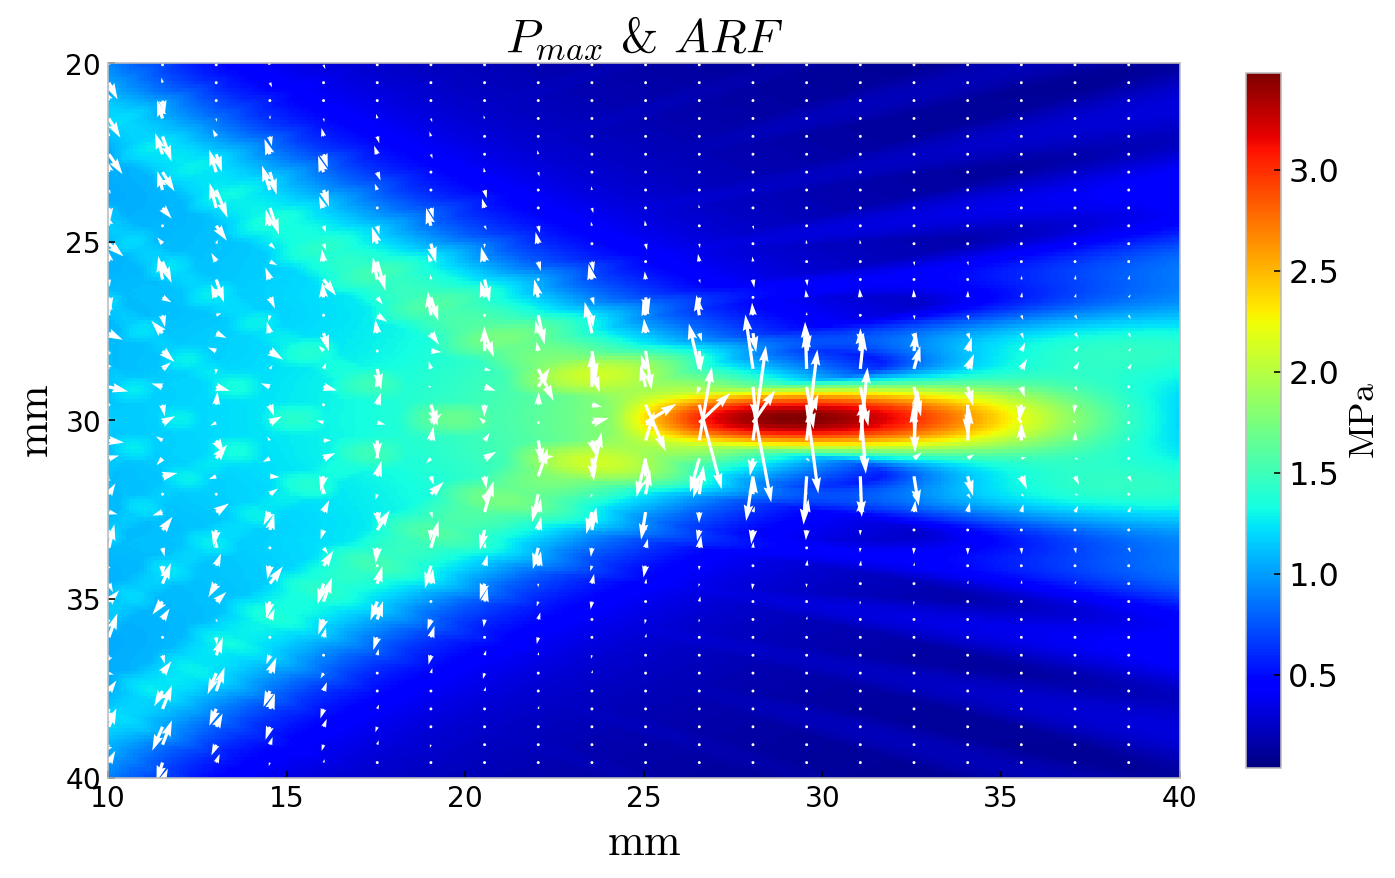

In [36]:
# plot single transducer max pressure along with quasi-planar ARF
plot_single_trxd_ARF_quiver(single_trxd.max_pressure, Fx_single_quasi, 
                            Fy_single_quasi, 
                            file_name='single_Pmax_ARF_QP', scale=6e-2, col=col,
                            dx=dx, Nx=Nx, dy=dy, Ny=Ny, X=X, Y=Y, qres=qres,
                            figure_path=None)

### Purely plane wave approximation 
This equation assumes no contribution to ARF along $i$ from particles traveling along directions $j \ne i$. 

$$F_i = -\rho_0 \langle \frac{\partial v_iv_j}{\partial x_j}\delta_{ij} \rangle$$

Therefore, we have:

\begin{equation}\tag{11}
\mathbf{F} = -\rho \begin{pmatrix}
\big\langle 2v_x\frac{\partial v_x}{\partial x}\big\rangle \\ 
\big\langle 2v_y\frac{\partial v_y}{\partial y}\big \rangle
\end{pmatrix} \enspace \in \mathbb{R}^2
\end{equation}

Note that in our single transducer setup we have a transducer that is sonicating along the $x$-axis. Therefore, any $v_y$ and its gradients will be zero. As such, it makes no sense for us to plot ARF along the $y$-axis, as there is no ARF in that direction. However, for the sake of completion the equation is still provided below. If your transducer is positioned along the $y$-axis, you want to use the ```Fy_single_planar``` term rather than the ```Fx_single_planar``` one. 

In [37]:
Fx_single_planar = - rho * temporal_ave((2 * single_trxd_vx * single_trxd_dvxdx)
, t1, t2, dt)
Fy_single_planar = - rho * temporal_ave((2 * single_trxd_vy * single_trxd_dvydy)
, t1, t2, dt)
# apply the -1 correction 
Fy_single_planar = - Fy_single_planar

# set maximum and minimum for F away from transducer surface 
Fx_max_single_planar = np.max(Fx_single_planar[:, col:-col])
Fx_min_single_planar = - Fx_max_single_planar

Fy_max_single_planar = np.max(Fy_single_planar[:, col:-col])
Fy_min_single_planar = - Fy_max_single_planar

# apply Gaussian filters to both Fx and Fy
filtered_Fx_single_planar = sp.ndimage.gaussian_filter(Fx_single_planar, sigma=0.9)
filtered_Fy_single_planar = sp.ndimage.gaussian_filter(Fy_single_planar, sigma=0.9)

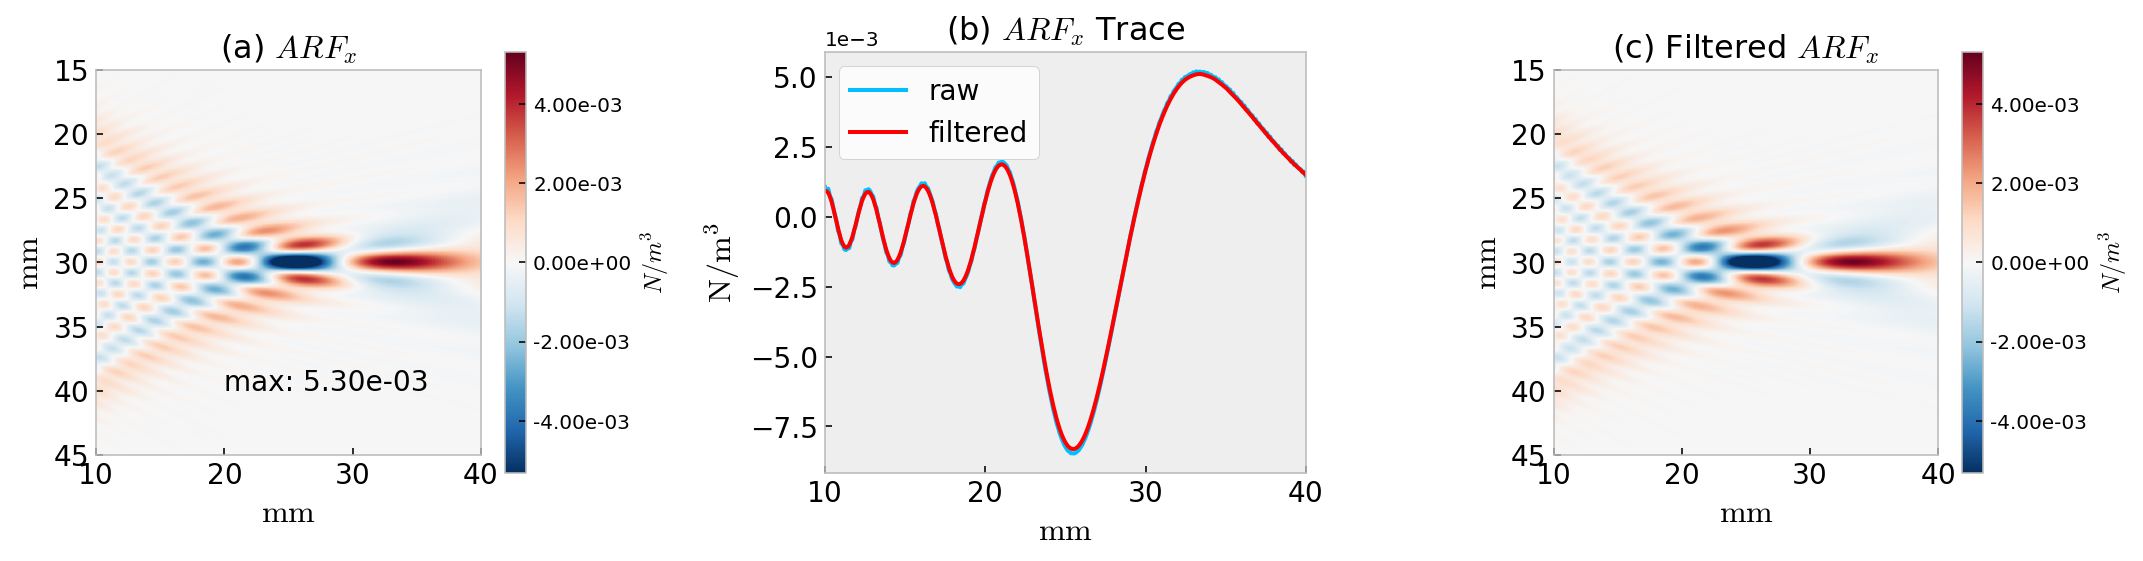

In [38]:
# plot single transducer purely-planar ARF along the x-axis 
plot_single_trxd_ARFx(Fx_single_planar, filtered_Fx_single_planar,
                      Fx_min_single_planar, Fx_max_single_planar, 
                      text_loc=[20, 40], col=col,
                      x=x, dx=dx, Nx=Nx, dy=dy, Ny=Ny, fr=fr,
                      file_name='single_trxd_PP_ARFx', figure_path=None)

Note that in the quiver plot below I have used ```Fy_single_planar``` just for the purposes of generating the meshgrid. But I have multiplied them by zero, since once again there is no ARF component in the $y$-direction. 

If your transducer is aligned with the $y$-axis, you want to multiply ```Fx_single_planar``` by zeros instead. 

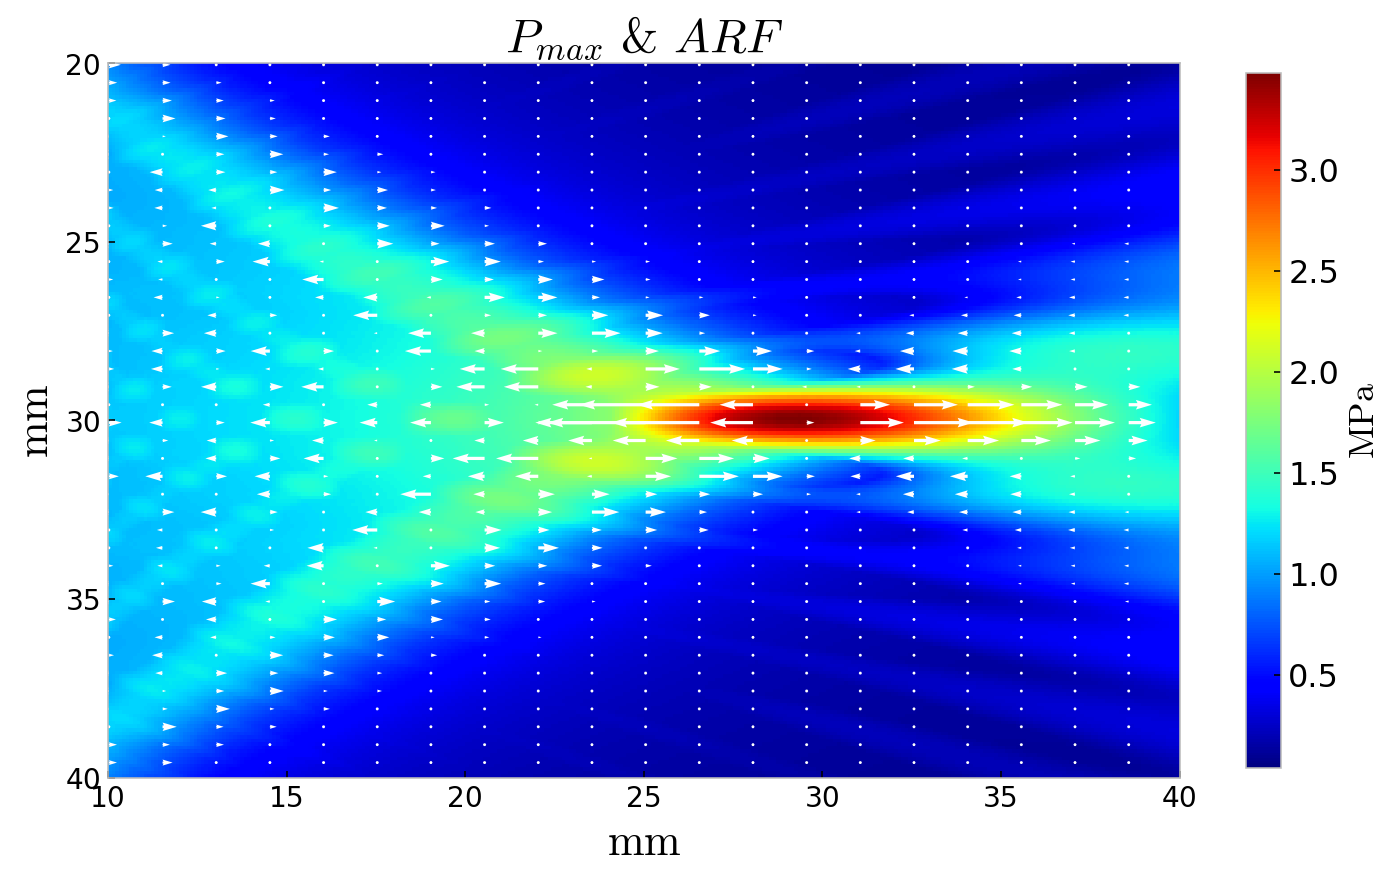

In [39]:
# plot single transducer max pressure along with quasi-planar ARF
plot_single_trxd_ARF_quiver(single_trxd.max_pressure, Fx_single_planar, 
                            Fy_single_planar * 0.0, 
                            file_name='single_Pmax_ARF_PP', scale=0.9e-1, col=col,
                            dx=dx, Nx=Nx, dy=dy, Ny=Ny, X=X, Y=Y, qres=qres,
                            figure_path=None)

## 2.2. Orthogonal Transducers

In part **1** of the notebook we learned that the complete form of the ARF varies greatly from the simplified forms, and especially since we use focused transducers for Focused Ultrasound (FUS), we should always use the complete form. However, for the sake of completeness, we will look at the case of orthogonal transducers at three stages, similar to the single transducer case. 



### Complete form 


### Mean Eulerian Excess Pressure
As before, we will first compute and plot $\langle p_E\rangle$. 

In [40]:
# extract the pressure 
p_orthogonal = orthogonal_trxd.pressure

In [41]:
# compute the first term in pE:
# time averaged pressure squared
p2_temporal_ave = temporal_ave(np.power(p_orthogonal[t1:t2, :, :], 2), 
                               t1, t2, dt=dt)
# compute the first term in pE:
pE1 = 1 / (2 * rho * c ** 2) * p2_temporal_ave

# compute the second term in pE: 
v_norm_sqrd = (np.power(orthogonal_trxd.vx[t1:t2, :, :], 2) + 
               np.power(orthogonal_trxd.vy[t1:t2, :, :], 2))
pE2 = 1 / 2 * rho * temporal_ave(v_norm_sqrd, t1, t2, dt=dt)

# compute <pE> = pE1 - pE2
pE_orth = pE1 - pE2

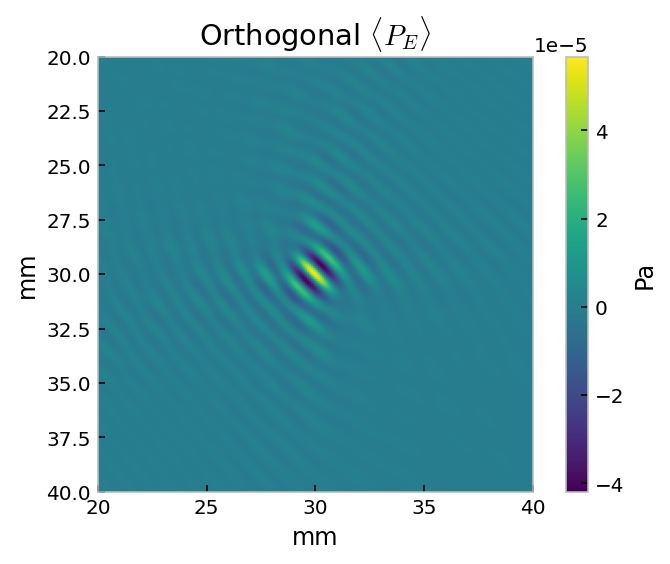

In [42]:
plt.imshow(pE_orth, extent=[0, 50, 50, 0])
plt.title(r'Orthogonal $\langle P_E \rangle$')
plt.colorbar(label='Pa')
plt.grid(False)
plt.xlabel('mm')
plt.ylabel('mm')
plt.xlim(20, 40)
plt.ylim(40, 20)
#plt.savefig(figure_path + 'pE_orthogonal', dpi=600)
plt.show()

In [43]:
dpEdx_orth = np.gradient(pE_orth, dx, axis=1)
dpEdy_orth = np.gradient(pE_orth, dx, axis=0)

as before, we will do a sanity check of the gradients for a random point in time. 

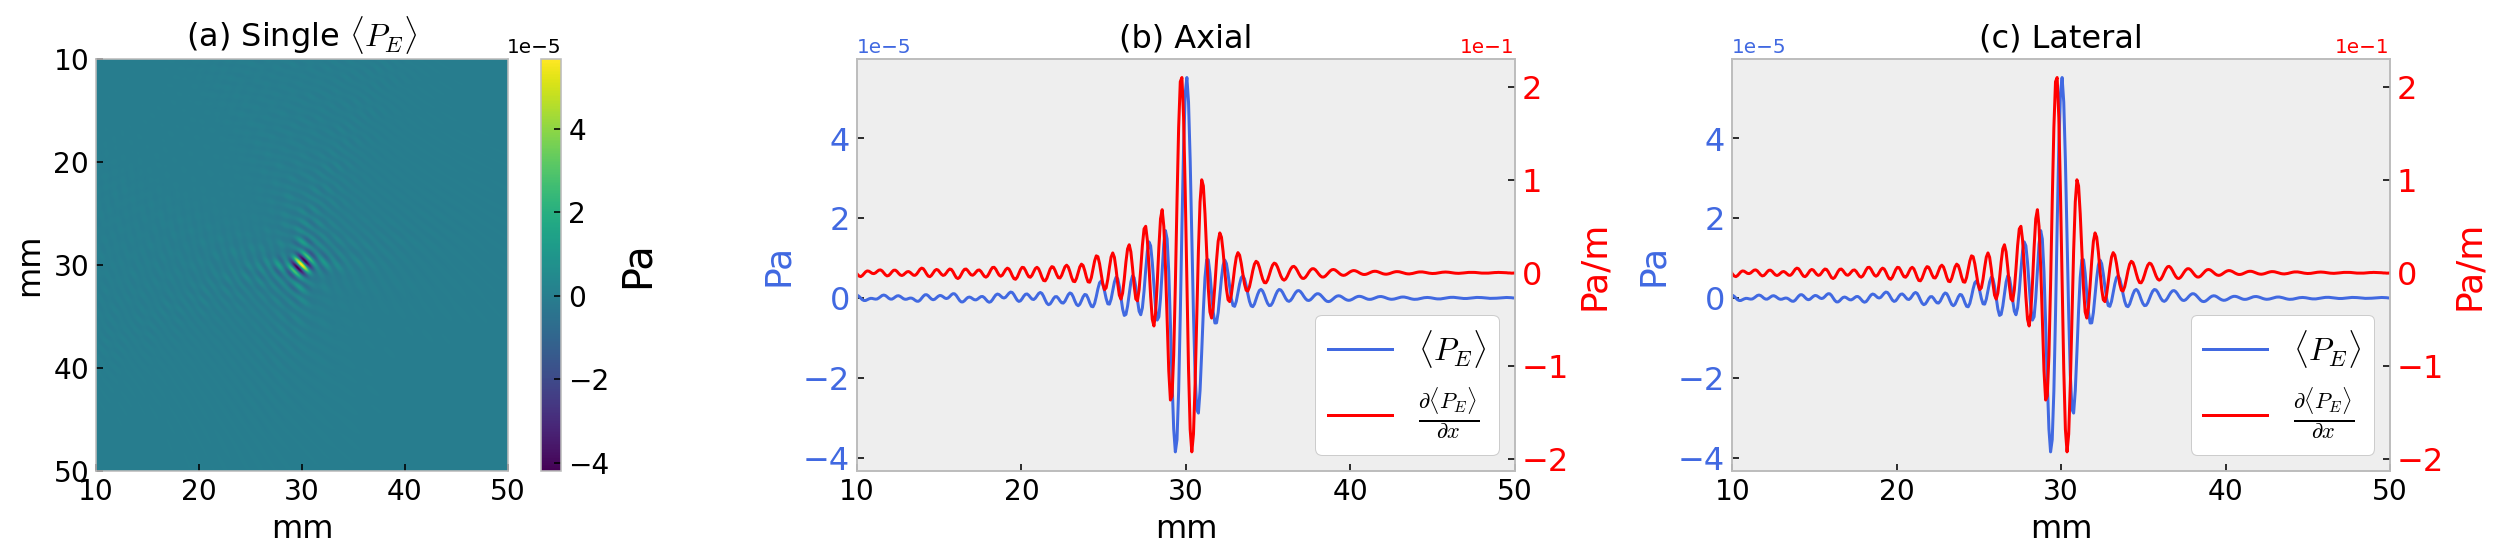

In [44]:
plot_Mean_Eulerian_Pressure(pE_orth, x, dx, fr, dpEdx_orth, 
                       dpEdy_orth, col, figure_path=None)

we will now set out to compute the gradients and choose the $v_x$ and $v_y$ components over the temporal span of interest, $[t_1, t_2]$. Remember that the gradients are already saved in ```orthogonal_trxd_grad```, an instance of the ```trxdGradients``` class. 

In [45]:
# slice vx and vy such that they have the same number of Nt as their gradients 
# we computed earlier, so that we can carry out element-wise multiplication
orthogonal_trxd_vx = orthogonal_trxd.vx[t1:t2, :, :]
orthogonal_trxd_vy = orthogonal_trxd.vy[t1:t2, :, :]
orthogonal_trxd_dvxdx = orthogonal_trxd_grad.dvxdx
orthogonal_trxd_dvxdy = orthogonal_trxd_grad.dvxdy
orthogonal_trxd_dvydx = orthogonal_trxd_grad.dvydx
orthogonal_trxd_dvydy = orthogonal_trxd_grad.dvydy

In [46]:
# <v(del. v) + (v.del)v>
orthogonal_trxd_vdelv_x = temporal_ave((
    2 * orthogonal_trxd_vx * orthogonal_trxd_dvxdx + 
    orthogonal_trxd_vx * orthogonal_trxd_dvydy + 
    orthogonal_trxd_vy * orthogonal_trxd_dvxdy), t1, t2, dt)

orthogonal_trxd_vdelv_y = temporal_ave((
    2 * orthogonal_trxd_vy * orthogonal_trxd_dvydy + 
    orthogonal_trxd_vy * orthogonal_trxd_dvxdx + 
    orthogonal_trxd_vx * orthogonal_trxd_dvydx), t1, t2, dt)

Fx_orth = - (dpEdx_orth + rho * orthogonal_trxd_vdelv_x)
Fy_orth = - (dpEdy_orth + rho * orthogonal_trxd_vdelv_y)
# apply the -1 correction 
Fy_orth = - Fy_orth

# set maximum and minimum for F away from transducer surface 
Fx_orth_max = np.max(Fx_orth[col:, col:])
Fx_orth_min = - Fx_orth_max

# also get the max along y for later comparison
Fy_orth_max = np.max(np.abs(Fy_orth[col:-col, col:-col]))
Fy_orth_min = - Fy_orth_max

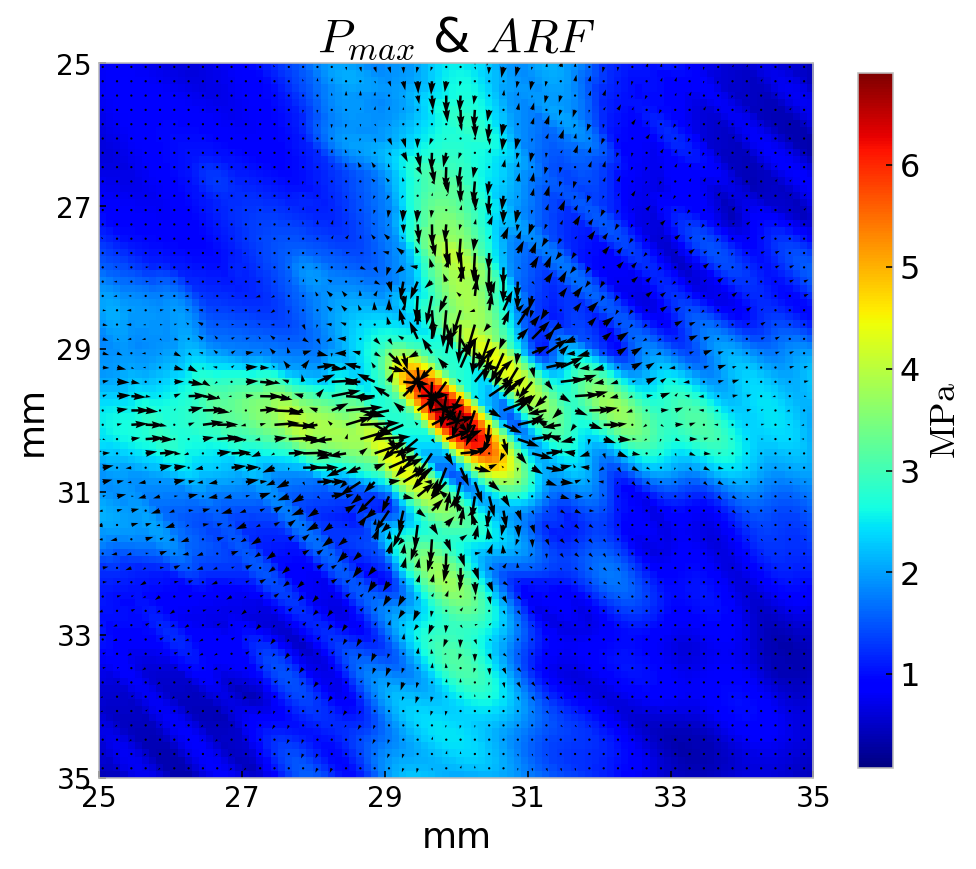

In [47]:
plot_orth_trxd_ARF_quiver(orthogonal_trxd.max_pressure, Fx_orth,
                          Fy_orth, x_pos=x_pos, y_pos=y_pos,
                          file_name='orthogonal_Pmax_ARF', 
                          scale=0.8e-1, qres=2, figure_path=None)

Note how the sinks seem to be located at the anti-nodes, while the sources are positioned at the nodes. That is, forces are convergent at the anti-nodes while they are divergent at the nodes. In acoustic levitation the interplay between the material properties of the suspended particle and the surrounding medium determine whether the particle will be trapped at the nodes or the anti-nodes. Essentially, this interplay determines where the stable and unstable equilibria are$^4$. Therefore, it should not come as a surprise if in this setup the stable equilibrium is at the anti-node while in most acoustic levitation setups it is at the nodes. 

to demonstrate the dual field of propagating and standing waves in the orthogonal transducer setup, we will create an animation of the pressure field as a function of time. Once you run the code below, you will see that along the diagonal axis, waves are propagating from the upper left corner to the lower right corner. And along the anti-diagonal axis, standing waves are present. 

In [48]:
#@title Function to generate orthogonal transducers animations (run this cell)
def animate_orthgonal_field(field, file_name, figure_path):
    fig = plt.figure(figsize=(6, 6))
    ims = []
    for i in range(50):
        im = plt.imshow(field[2300+i, :, :] * 1e-6, animated=True, 
                      cmap='jet', extent=(0, 50, 50, 0), 
                      vmin=-np.max(orthogonal_trxd.max_pressure) * 1e-6,
                      vmax=np.max(orthogonal_trxd.max_pressure) * 1e-6)
        ims.append([im])

    plt.xlabel('mm', fontsize=16)
    plt.ylabel('mm', fontsize=16)
    plt.xticks(np.arange(25, 36, 2), fontsize=14)
    plt.yticks(np.arange(25, 36, 2), fontsize=14)
    plt.xlim(25, 35)
    plt.ylim(35, 25)
    plt.grid(False)
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True)

    if figure_path == None:
        pass
    else:
        ani.save(figure_path + file_name + '.mp4', codec='mpeg4', dpi=500,  bitrate=1e4)
    
    plt.show()

def animate_diag_antidiag_pressures(pressure, axis, file_name, color, figure_path):
    fig = plt.figure(figsize=(8, 4))
    ims = []
    for i in range(50):
        im, = plt.plot(axis, pressure[i] * 1e-6, 
                    animated=True, color=color)
        ims.append([im])

    plt.xlabel('mm', fontsize=16)
    plt.ylabel('MPa', fontsize=16)
    plt.xticks(np.arange(25, 25 + 10 *np.sqrt(2), 2), fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(25, 25 + 10 *np.sqrt(2))
    plt.grid(False)

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True)

    plt.tight_layout()

    if figure_path == None:
        pass
    else:
        ani.save(figure_path + file_name + '.mp4', codec='mpeg4', dpi=600, bitrate=1e4)

    plt.show()

In [49]:
# # uncomment below to animate the orthogonal transducers pressure field 
# animate_orthgonal_field(orthogonal_trxd.pressure, 
#                         file_name='orthogonal_pressure_field',
#                        figure_path=None)

In order to look at the pressure traces along the diagonal axis, we could call ``np.diag`` to slice the orthogonal pressure field for any given point in time. To do the same for the anti-diagonal axis, we need to first rotate the field by calling ``np.rot90`` and then call ``np.diag`` on the rotated field. Also, note that the number of samples along the diagonal are the same as along $x=y=100\ \text{pts}$. However, since we are slicing along the diagonal of a square, the actual length of the diagonal is $\sqrt{2}\times$ that of $x=y=10\ mm$. We will implement this in ```diagonal_axis``` parameter below. 

In [50]:
# trim the pressure field to area of interest: x:25mm to 35mm, y:25mm to 35mm
orthogonal_pressure_trimmed = orthogonal_trxd.pressure[:, 250:350, 250:350]

# slice the trimmed pressure along the diagonal axis 
diagonal_pressures = [
                      np.diag(orthogonal_pressure_trimmed[2300+i, :, :])
                      for i in range(N_T) 
]
# slice the trimmed pressure along the anti-diagonal axis 
antidiagonal_pressures = [
                          np.diag(np.rot90(
                              orthogonal_pressure_trimmed[2300+i, :, :])) 
                          for i in range(N_T)
]

# define the length of the diagonal axis. 
diagonal_axis = np.linspace(25, 25 + 10 * np.sqrt(2), 100)

In [51]:
# # uncomment to plot the diagonal trace
# animate_diag_antidiag_pressures(diagonal_pressures, diagonal_axis, 
#                                 'orthogonal_pressure_diagonal', 
#                                 color='r', figure_path=None)

In [52]:
# # uncomment to plot the anti-diagonal trace
# animate_diag_antidiag_pressures(antidiagonal_pressures, diagonal_axis, 
#                                 'orthogonal_pressure_antidiagonal', 
#                                 color='dodgerblue', figure_path=None)

The code blocks above will generate an animation to show the standing and propagating waves as well as the 2D plot of the pressure field. For publication purposes, here I will create a static one as well:

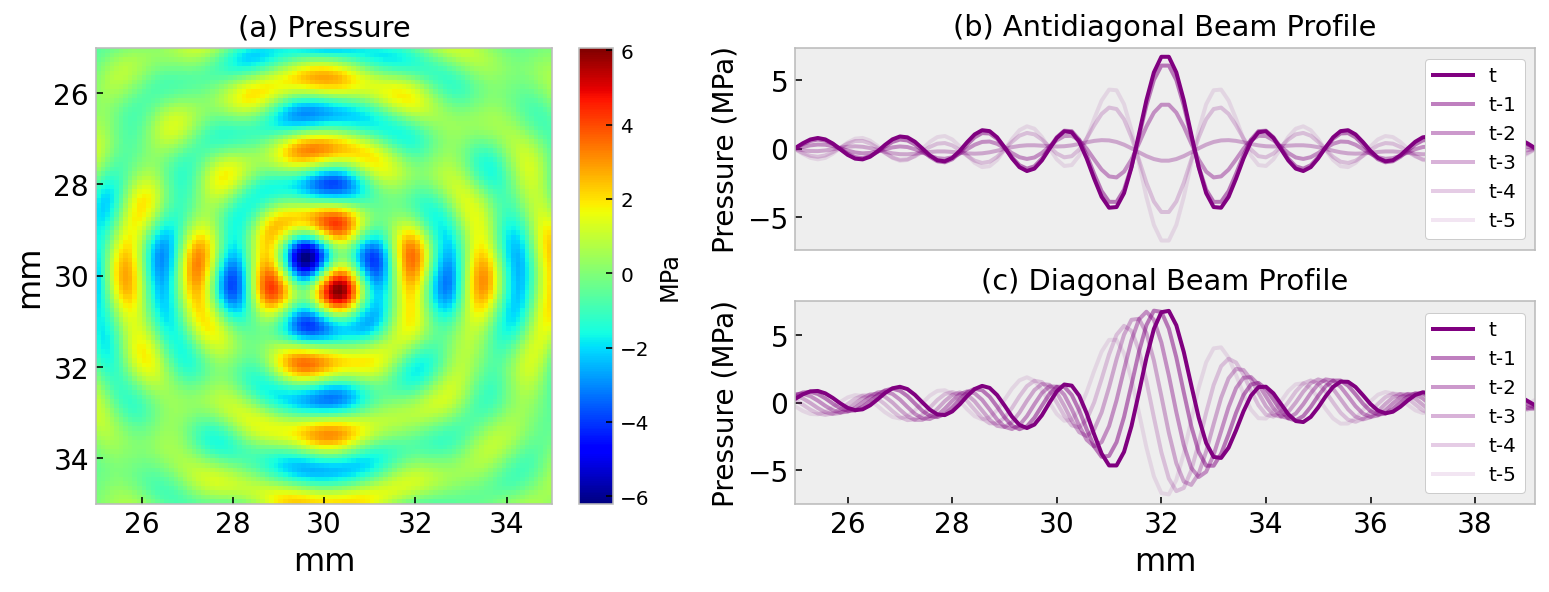

In [53]:
plot_propagation_snapshot(orthogonal_pressure_trimmed, antidiagonal_pressures,
                              diagonal_pressures,
                              diagonal_axis, 'dual_pressure_field', figure_path=None)

# 3.&nbsp;Where does $2\alpha I/c$ come from?

Since this equation is routinely used in the field it is vital to understand its derivation and underlying assumptions in order to gain insight into its limitations. 

We start off with a purely planar wave propagating along the $x$-axis. That is, 

\begin{equation}
F_x = -\rho_0 \frac{\partial \langle v_x^2 \rangle}{\partial x}
\end{equation}

for a plane wave, we have $p=\rho_0 c_0 v_x$. We can rearrange this and write $v_x = \frac{p}{\rho_0 c_0}$. Substituting this for $v_x$, 

\begin{equation}
F_x = -\rho_0 \frac{\partial}{\partial x}\langle \frac{p^2}{\rho_0^2 c_0^2}\rangle = -\frac{1}{\rho_0 c_0^2}\frac{\partial}{\partial x}\langle p^2 \rangle = -\frac{1}{Zc_0}\frac{\partial}{\partial x}\langle p^2\rangle
\end{equation}

We know that instantaneous intensity at point x in space is: $I(x,t)=\frac{p(x, t)^2}{Z}$. By taking the acoustic impedance term, $Z$, inside the temporal average operator, we can substitue $I(x,t)$:

\begin{equation}\tag{12}
F_x = -\frac{1}{c_0}\frac{\partial}{\partial x}\big\langle \frac{p(x,t)^2}{Z}\big\rangle = -\frac{1}{c_0}\frac{\partial}{\partial x}\big\langle I(x, t)\big\rangle
\end{equation}


In order to compute the temporal average over the instantaneous intensity, we need to have an explicit model for intensity. Since the assumption is planar waves propagating along the $x$-axis, we can represent this with either a $sin$ wave or a $cos$ wave. I used $sin$:

\begin{equation}
I(x,t) = \frac{p(x,t)^2}{Z} = \frac{\big(p_0(x)sin(\omega t - kx)\big)^2}{Z}
\end{equation}

We will take the temporal average of this term over one wave period, $T=\frac{\pi}{\omega}$

\begin{equation}
\langle I(x, t)\rangle = \frac{1}{T}\int_{0}^{T}\frac{p_0(x)^2sin^2(\omega t - kx)}{Z}dt = \frac{p_0(x)^2}{ZT}\int_0^{T}\frac{1}{2}\big(1 - cos(2\omega t - 2kx )\big)dt
\end{equation}

where we have used the half-angle identity to go from $sin^2(\theta)$ to $cos(2\theta)$. 


\begin{equation}
\frac{p_0(x)^2}{ZT}\int_0^{T}\frac{1}{2}\big(1 - cos(2\omega t - 2kx )\big)dt = \frac{p_0(x)^2}{2ZT}\int_{0}^{T}dt - \frac{p_0(x)^2}{2ZT}\int_{0}^{T}cos(2\omega t - 2kx)dt = \frac{p_0(x)^2}{2Z}t\big]_0^T = \frac{p_0(x)^2}{2Z}
\end{equation}

Therefore, temporal average intensity at any point $x$ in space is:

\begin{equation}\tag{13}
\langle I(x,t)\rangle = I_{TA}(x) = \frac{p_0(x)^2}{2Z}
\end{equation}

substituting (13) for $\langle I(x,t)\rangle$ in Eq. (12), we can rewrite $F_x$:

\begin{equation}\tag{14}
F_x = -\frac{1}{c_0}\frac{\partial}{\partial x}\frac{p_0(x)^2}{2Z}
\end{equation}

Eq. (14) suggests that if there is no pressure gradient, then $ARF$ is zero. The very basic assumption in this equation is that waves are purely planar. In the absence of any focusing, planar waves will present no gradients. One way to induce a gradient is to assume an exponentially attenuating medium:

\begin{equation}
p_0(x)=p_{max}e^{-\alpha x} \Rightarrow F_x = -\frac{1}{2c_0Z}\frac{d}{dx}p_0(x)^2=-\frac{1}{2c_0 Z}\frac{d}{dx}p_{max}^2e^{-2\alpha x} = -\frac{1}{2c_0Z}(-2\alpha)p_{max}^2e^{-2\alpha x}
\end{equation}

simplifying and factoring out the exponential term, we have:

\begin{equation}\tag{15}
F_x = \frac{\alpha}{c_0Z}\big(p_{max}e^{-\alpha x} \big)^2 = \frac{\alpha}{c_0}\frac{p_0(x)^2}{Z}
\end{equation}

multiplying and dividing Eq. (15) by 2:

\begin{equation}\tag{16}
\frac{2\alpha}{c_0}\frac{p_0(x)^2}{2Z} = \frac{2\alpha}{c_0}I_{TA}(x) \therefore F_x = \frac{2\alpha I}{c_0}
\end{equation}


Eq. (16) is the formula for acoustic radiation force for a purely planar continuous wave propagating in an exponentially attenuating medium of coefficient $\alpha\ (Np/m)$. 





# 4.&nbsp; Spatial Resolution

Here we will show the full width at half maximum FWHM resolutions in each setup. 

In [54]:
# simulate the antiparallel scenario by adding two mirrored single transducers 
antiparallel_trxd = np.max(single_trxd.pressure[2000:2300, :, col:] + 
                            np.flip(single_trxd.pressure[2000:2300, :, col:], 
                                    axis=2), axis=0)

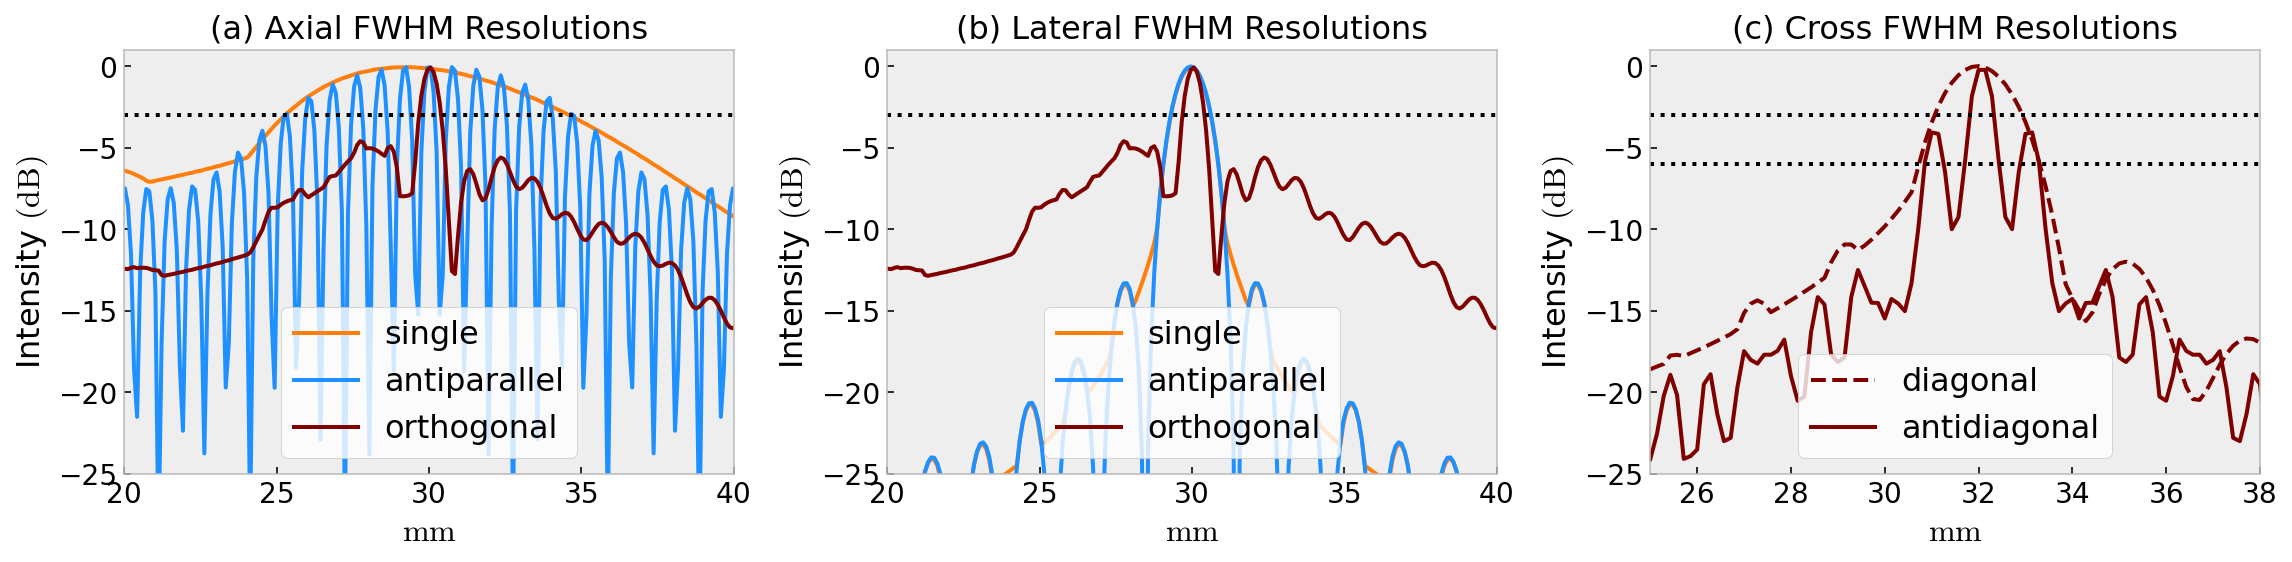

In [55]:
plot_FWHM_dB(single_trxd, antiparallel_trxd, orthogonal_trxd, orthogonal_pressure_trimmed,
             col, figure_path=None)

diagonal FWHM: $32.6-29.6 = 1.8\ mm$

antidiagonal FWHM: $31.7 - 30.8 =0.5\ mm$

single lateral FWHM: $30.7-29.3 = 1.4\ mm$

antiparallel lateral FWHM: $30.7 - 29.3 = 1.4\ mm$

orthogonal lateral FWHM: $30.7 - 29.7 = 1.0\ mm$

single axial FWHM: $34.5 - 25.2 = 9.3\ mm$ 

antiparallel axial FWHM: $34.5 - 25.2 = 9.3\ mm$

orthogonal axial FWHM: $30.4 - 29.6 = 0.8\ mm$

### Target Volume
Since the target is considered to be an ellipsoid, once its major and minor axes are identified we can proceed to compute its FWHM volume (as defined by the -3 dB line of the intensity) as follows: 

\begin{equation}
V = \frac{4}{3}\pi \big(a/2 \big) \big(b/2 \big) \big(c/2 \big)
\end{equation}

dimensions b and c have similar lengths, so we can just collapse those into one: 

\begin{equation}
V = \frac{4}{3}\pi \big(a/2 \big) \big(b/2 \big) ^ 2
\end{equation}


In [56]:
# function to compute the FWHM volume of the target
def FWHM_volume(a, b):
    return (4 / 3) * np.pi * (a / 2) * (b / 2) ** 2

In [57]:
print('Single transducer FWHM volume: %0.2f mm3' %FWHM_volume(9.3, 1.4))
print('Antiparallel transducer FWHM volume: %0.2f mm3' %FWHM_volume(9.3, 1.4))
print('Orthogonal transducer FWHM volume: %0.2f mm3' %FWHM_volume(1.8, 0.5))

Single transducer FWHM volume: 9.54 mm3
Antiparallel transducer FWHM volume: 9.54 mm3
Orthogonal transducer FWHM volume: 0.24 mm3


# 5.&nbsp;Extra Figures

Some of the below figures show up in the publication. 

### Effect of phase offset on orthogonal pressure field
Let's take a look at the effect of phase offset on transducers in orthogonal regime. We will look at two phase offsets of $\frac{T}{2}$ and $\frac{T}{4}$ where $T$ is the period. 

In [58]:
single_trxd_left = single_trxd.pressure[2000:2300]
# simulate the top transducer by inverting and rotating the left transducer
single_trxd_top = np.rot90(np.flip(single_trxd_left, axis=2), k=1, axes=(1, 2))
inphase_superposition = single_trxd_left + single_trxd_top

In [59]:
half_phase = int(N_T / 2)
quarter_phase = int(N_T / 4)

halfphase_superposition = single_trxd_left[:-half_phase, :, :] + \
single_trxd_top[half_phase:, :, :]

quarterphase_superposition = single_trxd_left[:-quarter_phase, :, :] + \
single_trxd_top[quarter_phase:, :, :]

In [60]:
vmax = np.max(inphase_superposition)
vmin = np.min(inphase_superposition)

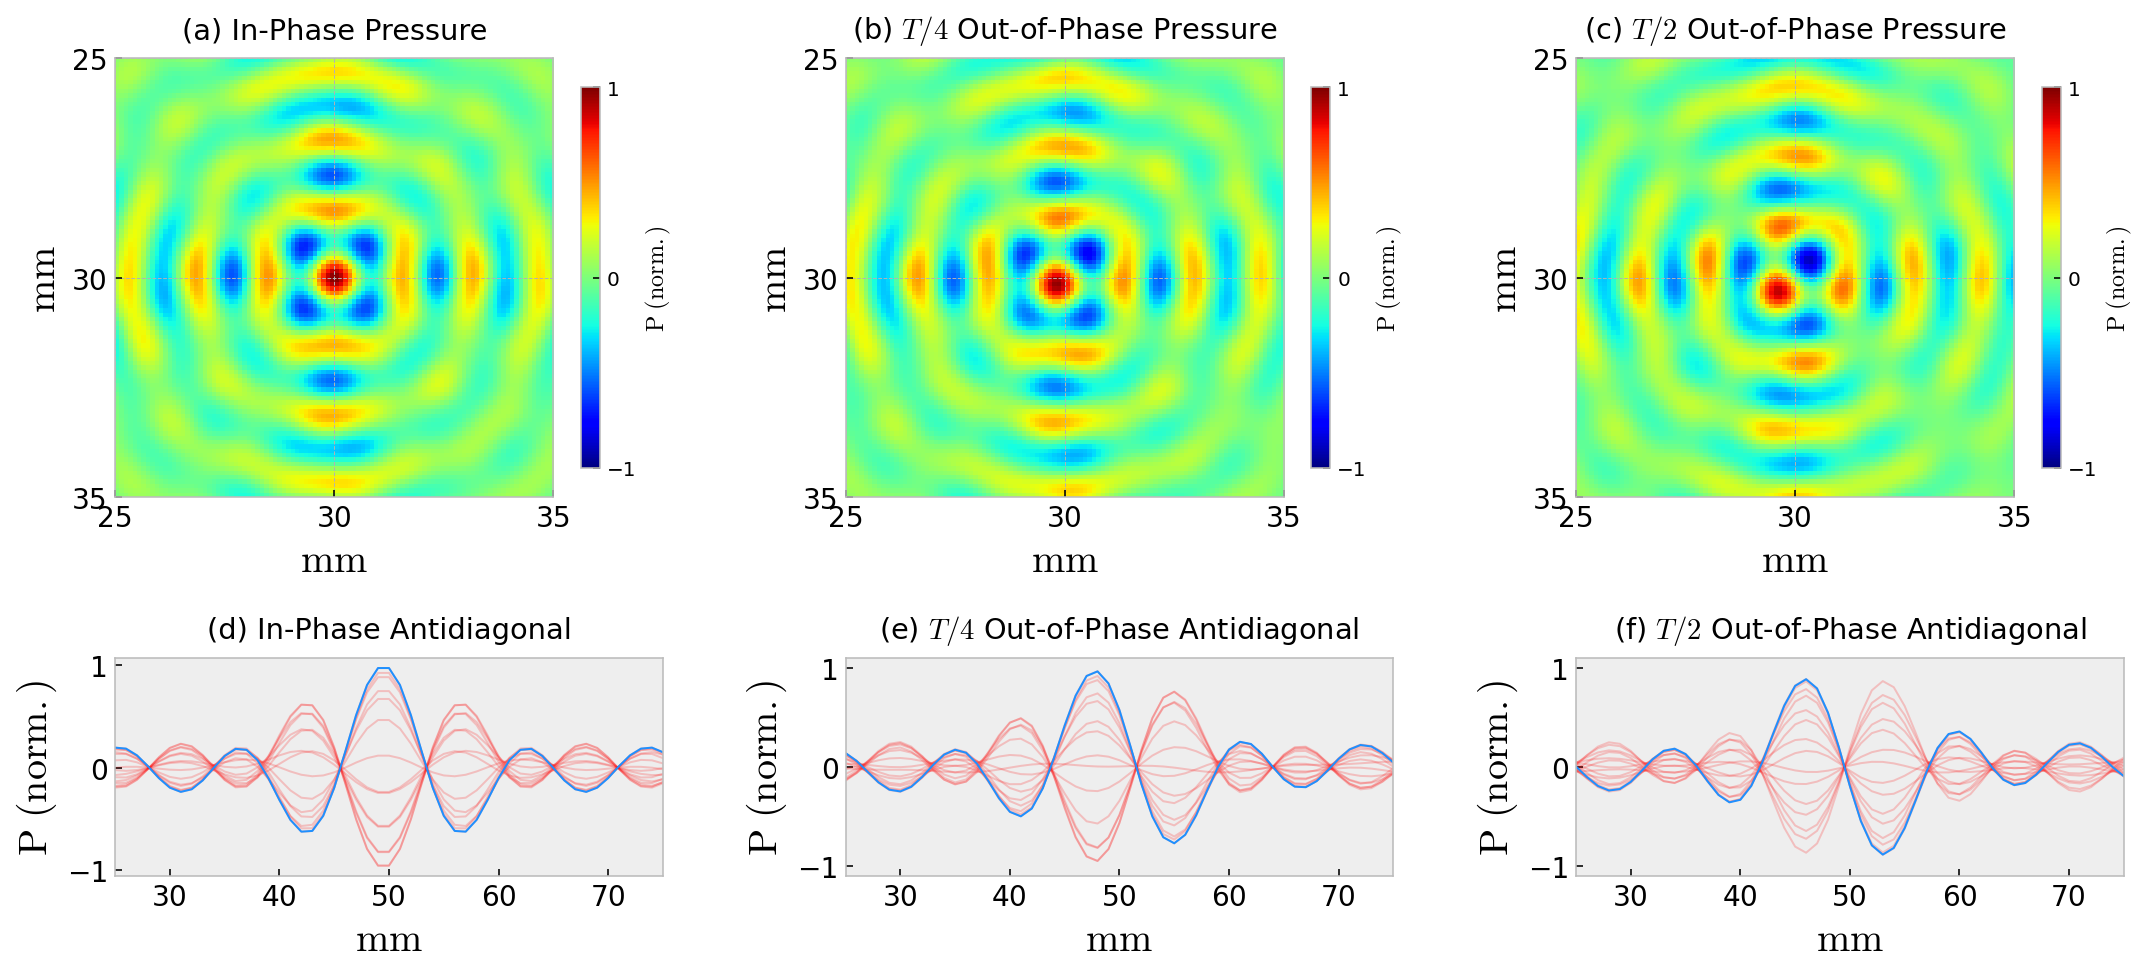

In [61]:
fig = plt.figure(figsize=(18, 8), constrained_layout=False)
gs = GridSpec(3, 6, figure=fig, wspace=1, hspace=0.5)

ax1 = fig.add_subplot(gs[:2, :2])
ax1.set_title('(a) In-Phase Pressure', pad=10)
plt1 = ax1.imshow(inphase_superposition[39] / vmax, cmap='jet', 
                  extent=(0, 50, 50, 0), vmin=-1, vmax=1)
fig.colorbar(ax = ax1, mappable = plt1, orientation = 'vertical', 
            ticklocation = 'right', label='$\mathrm{P\ (norm.)}$', aspect=20, 
             shrink=0.7, ticks=np.arange(-1, 1.1, 1))
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.set_xlabel(r'$\mathrm{mm}$', fontsize=20)
ax1.set_ylabel(r'$\mathrm{mm}$', fontsize=20)
ax1.set_xlim(25, 35)
ax1.set_ylim(35, 25)
ax1.set_yticks(np.arange(25, 36, 5))
ax1.set_xticks(np.arange(25, 36, 5))


ax2 = fig.add_subplot(gs[:2, 2:4])
ax2.set_title('(b) $T/4$ Out-of-Phase Pressure', pad=10)
plt2 = ax2.imshow(quarterphase_superposition[32] / vmax, cmap='jet', 
                  extent=(0, 50, 50, 0), vmin=-1, vmax=1)
fig.colorbar(ax = ax2, mappable = plt2, orientation = 'vertical', 
            ticklocation = 'right', label='$\mathrm{P\ (norm.)}$', aspect=20, 
             shrink=0.7, ticks=np.arange(-1, 1.1, 1))
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.set_xlabel(r'$\mathrm{mm}$', fontsize=20)
ax2.set_ylabel(r'$\mathrm{mm}$', fontsize=20)
ax2.set_xlim(25, 35)
ax2.set_ylim(35, 25)
ax2.set_yticks(np.arange(25, 36, 5))
ax2.set_xticks(np.arange(25, 36, 5))

ax3 = fig.add_subplot(gs[:2, 4:6])
ax3.set_title('(c) $T/2$ Out-of-Phase Pressure', pad=10)
plt3 = ax3.imshow(halfphase_superposition[25] / vmax, cmap='jet', 
                  extent=(0, 50, 50, 0), vmin=-1, vmax=1)
fig.colorbar(ax = ax3, mappable = plt3, orientation = 'vertical', 
            ticklocation = 'right', label='$\mathrm{P\ (norm.)}$', aspect=20, 
             shrink=0.7, ticks=np.arange(-1, 1.1, 1))
ax3.tick_params(axis='both', which='major', labelsize=14)
ax3.set_xlabel(r'$\mathrm{mm}$', fontsize=20)
ax3.set_ylabel(r'$\mathrm{mm}$', fontsize=20)
ax3.set_xlim(25, 35)
ax3.set_ylim(35, 25)
ax3.set_yticks(np.arange(25, 36, 5))
ax3.set_xticks(np.arange(25, 36, 5))

ax4 = fig.add_subplot(gs[2, 0:2])
ax4.set_title('(d) In-Phase Antidiagonal', pad=10)
for i in range(0, 15):
    ax4.plot(np.diag(np.rot90(
      inphase_superposition[(i + 1) * 3][250:350, 250:350])) / vmax, 
           color='red', alpha=0.2, lw=1)
ax4.plot(np.diag(np.rot90(inphase_superposition[39][250:350, 250:350])) / vmax, 
           color='dodgerblue', alpha=1, lw=1)
ax4.tick_params(axis='both', which='major', labelsize=14)
ax4.set_xlabel(r'$\mathrm{mm}$', fontsize=20)
ax4.set_ylabel(r'$\mathrm{P\ (norm.)}$', fontsize=20)
ax4.grid(False)
ax4.set_xlim(25, 75)


ax5 = fig.add_subplot(gs[2, 2:4])
ax5.set_title('(e) $T/4$ Out-of-Phase Antidiagonal', pad=10)
for i in range(0, 15):
    ax5.plot(np.diag(np.rot90(
      quarterphase_superposition[(i + 1) * 3][250:350, 250:350], k=-1)) / vmax, 
           color='red', alpha=0.2, lw=1)
ax5.plot(np.diag(np.rot90(
    quarterphase_superposition[32][250:350, 250:350], k=-1)) / vmax, 
           color='dodgerblue', alpha=1, lw=1)
ax5.tick_params(axis='both', which='major', labelsize=14)
ax5.set_xlabel(r'$\mathrm{mm}$', fontsize=20)
ax5.set_ylabel(r'$\mathrm{P\ (norm.)}$', fontsize=20)
ax5.grid(False)
ax5.set_xlim(25, 75)
ax5.set_ylim(-1.1, 1.1)

ax6 = fig.add_subplot(gs[2, 4:6])
ax6.set_title('(f) $T/2$ Out-of-Phase Antidiagonal', pad=10)
for i in range(0, 15):
    ax6.plot(np.diag(np.rot90(
      halfphase_superposition[(i + 1) * 3][250:350, 250:350], k=-1)) / vmax, 
           color='red', alpha=0.2, lw=1)
ax6.plot(np.diag(np.rot90(
    halfphase_superposition[25][250:350, 250:350], k=-1)) / vmax, 
           color='dodgerblue', alpha=1, lw=1)
ax6.tick_params(axis='both', which='major', labelsize=14)
ax6.set_xlabel(r'$\mathrm{mm}$', fontsize=20)
ax6.set_ylabel(r'$\mathrm{P\ (norm.)}$', fontsize=20)
ax6.grid(False)
ax6.set_xlim(25, 75)
ax6.set_ylim(-1.1, 1.1)

#plt.savefig(figure_path + 'phase_shift_comparison', dpi=600)
plt.show()

We see that interestingly even when the two transducers are out of phase by $\frac{T}{2}$ (half period), pressures are not annihilated, instead the antinode at the focus has turned into a node. It is crucial to know this and keep track of in experimental setups as the mechanical properties and ARF are completely different in nodes and antinodes. 

In [62]:
# # uncomment to generate animations of the above plot 
# fig = plt.figure(figsize=(8, 4))
# ims = []
# for i in range(50):
#     im1, = plt.plot(np.diag(np.rot90(inphase_superposition[i][250:350, 250:350])) / vmax, animated=True, label='in phase' if i==0 else '', color='dodgerblue')
#     im2, = plt.plot(np.diag(np.rot90(outofphase_superposition[i][250:350, 250:350])) / vmax, animated=True, label='out of phase' if i==0 else '', color='red')
#     ims.append([im1, im2])

# plt.xlabel('mm', fontsize=16)
# plt.ylabel('mm', fontsize=16)
# plt.grid(False)
# ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True)
# ani.save(figure_path + 'Comparison' + '.mp4', codec='mpeg4', dpi=500,  bitrate=1e4)
# plt.legend()
# plt.show()

# #plt.plot(np.diag(np.rot90(inphase_superposition[0][250:350, 250:350])))
# #plt.plot(np.diag(np.rot90(outofphase_superposition[20][250:350, 250:350])))

In [63]:
# fig = plt.figure(figsize=(8, 8))
# ims = []
# for i in range(50):
#     im = plt.imshow(inphase_superposition[0+i, :, :] * 1e-6, animated=True, 
#                     cmap='jet', extent=(0, 50, 50, 0), 
#                     vmin=-np.max(orthogonal_trxd.max_pressure) * 1e-6,
#                     vmax=np.max(orthogonal_trxd.max_pressure) * 1e-6)
#     ims.append([im])

# plt.xlabel('mm', fontsize=16)
# plt.ylabel('mm', fontsize=16)
# plt.xticks(np.arange(25, 36, 2), fontsize=14)
# plt.yticks(np.arange(25, 36, 2), fontsize=14)
# plt.xlim(25, 35)
# plt.ylim(35, 25)
# plt.grid(False)
# ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True)
# ani.save(figure_path + 'InPhase' + '.mp4', codec='mpeg4', dpi=500,  bitrate=1e4)
# plt.show()

### $ARF_x$ under various modeling assumptions

Here we plot the x-component of the ARF for the general ARF model, under the quasi planar assumption, and lastly under the purely planar assumption. 

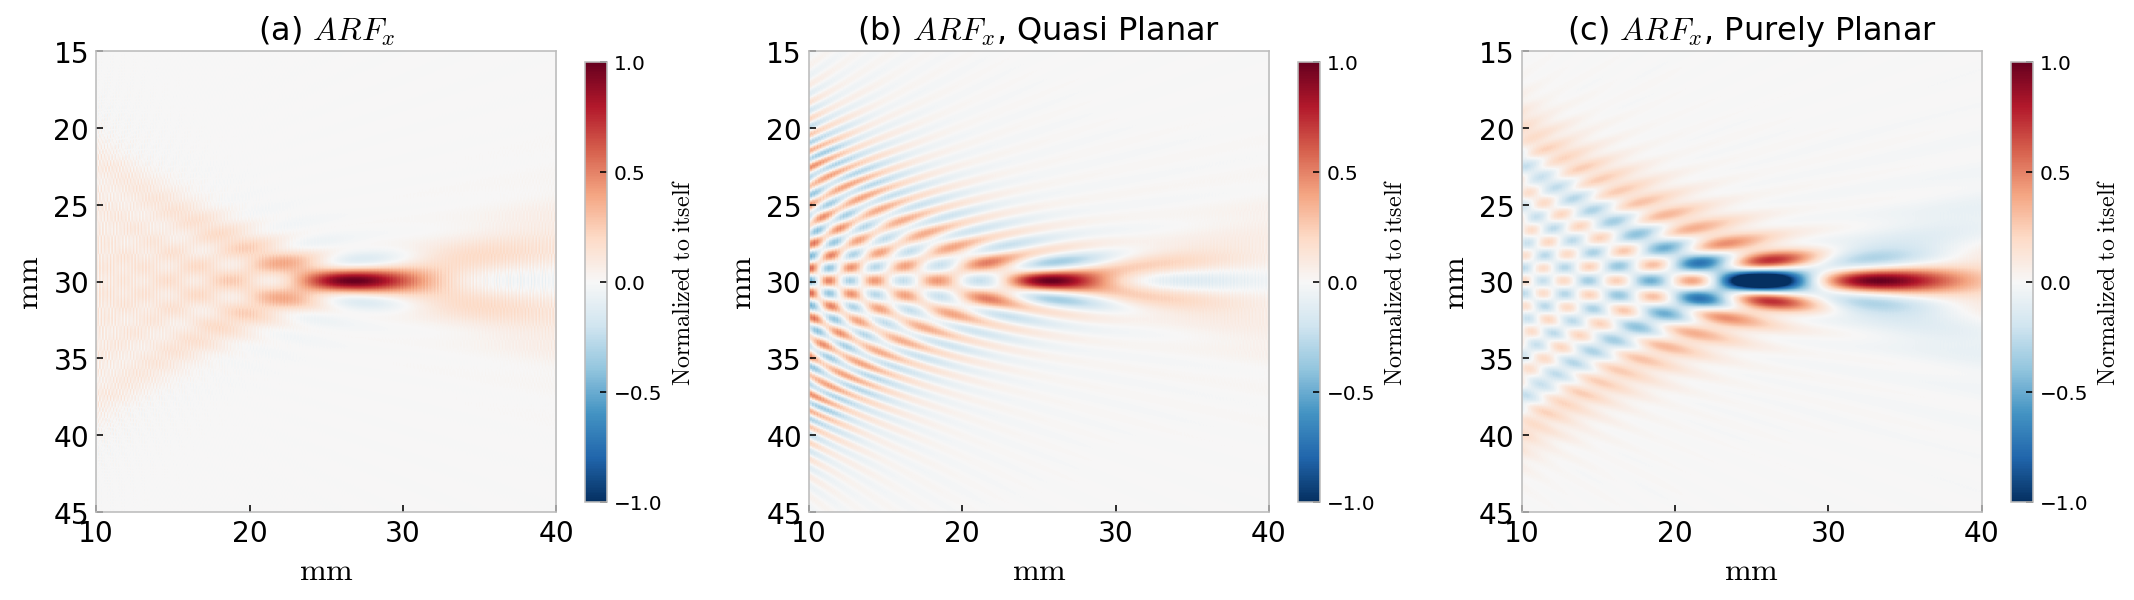

In [64]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('(a) $ARF_x$', fontsize=16)
plt.imshow(Fx_single[:, 50:] / Fx_single_max, cmap='RdBu_r', 
           extent=(5, 50, 50, 0), vmin=-1, vmax=1)
plt.colorbar(label='$\mathrm{Normalized\ to\ itself}$', 
             shrink=0.65, ticks=np.arange(-1, 1.1, 0.5))
plt.xlim(10, 40)
plt.ylim(45, 15)
plt.ylabel(r'$\mathrm{mm}$', fontsize=16)
plt.xlabel(r'$\mathrm{mm}$', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(False)

plt.subplot(1, 3, 2)
plt.title('(b) $ARF_x$, Quasi Planar', fontsize=16)
plt.imshow(Fx_single_quasi[:, 50:] / Fx_max_single_quasi, cmap='RdBu_r', 
           extent=(5, 50, 50, 0), vmin=-1, vmax=1)
plt.colorbar(label='$\mathrm{Normalized\ to\ itself}$', 
             shrink=0.65, ticks=np.arange(-1, 1.1, 0.5))
plt.xlim(10, 40)
plt.ylim(45, 15)
plt.ylabel(r'$\mathrm{mm}$', fontsize=16)
plt.xlabel(r'$\mathrm{mm}$', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(False)

plt.subplot(1, 3, 3)
plt.title('(c) $ARF_x$, Purely Planar', fontsize=16)
plt.imshow(Fx_single_planar[:, 50:] / Fx_max_single_planar, cmap='RdBu_r', 
           extent=(5, 50, 50, 0), vmin=-1, vmax=1)
plt.colorbar(label='$\mathrm{Normalized\ to\ itself}$', 
             shrink=0.65, ticks=np.arange(-1, 1.1, 0.5))
plt.xlim(10, 40)
plt.ylim(45, 15)
plt.ylabel(r'$\mathrm{mm}$', fontsize=16)
plt.xlabel(r'$\mathrm{mm}$', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(False)

plt.tight_layout()
#plt.savefig(figure_path + 'ARF_x_comparison', dpi=600)
plt.show()

### $ARF_y$ under various modeling assumptions

Here we plot the y-component of the ARF for the general ARF model, under the quasi planar assumption, and lastly under the purely planar assumption. 

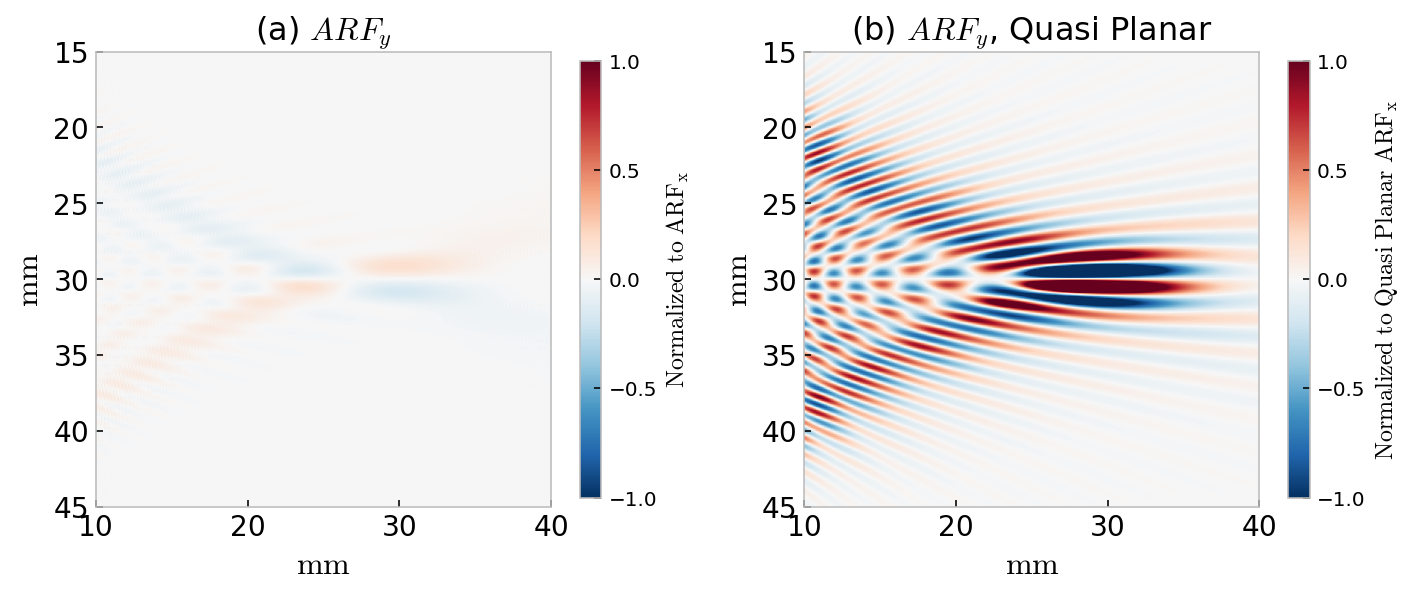

In [65]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('(a) $ARF_y$', fontsize=16)
plt.imshow(Fy_single[:, 50:] / Fx_single_max, cmap='RdBu_r',
           extent=(5, 50, 50, 0), vmin=-1, vmax=1)
plt.colorbar(label='$\mathrm{Normalized\ to\ ARF_x}$', 
             shrink=0.65, ticks=np.arange(-1, 1.1, 0.5))
plt.xlim(10, 40)
plt.ylim(45, 15)
plt.ylabel(r'$\mathrm{mm}$', fontsize=16)
plt.xlabel(r'$\mathrm{mm}$', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(False)

plt.subplot(1, 2, 2)
plt.title('(b) $ARF_y$, Quasi Planar', fontsize=16)
plt.imshow(Fy_single_quasi[:, 50:] / Fx_max_single_quasi, 
           cmap='RdBu_r', extent=(5, 50, 50, 0), vmin=-1, vmax=1)
plt.colorbar(label='$\mathrm{Normalized\ to\ Quasi\ Planar\ ARF_x}$', 
             shrink=0.65, ticks=np.arange(-1, 1.1, 0.5))
plt.xlim(10, 40)
plt.ylim(45, 15)
plt.ylabel(r'$\mathrm{mm}$', fontsize=16)
plt.xlabel(r'$\mathrm{mm}$', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(False)


plt.tight_layout()
#plt.savefig(figure_path + 'ARF_y_comparison', dpi=600)
plt.show()

### $ARF$ under various modeling assumptions

Here we plot the overall ARF vectors for the general ARF model, under the quasi planar assumption, and lastly under the purely planar assumption. 

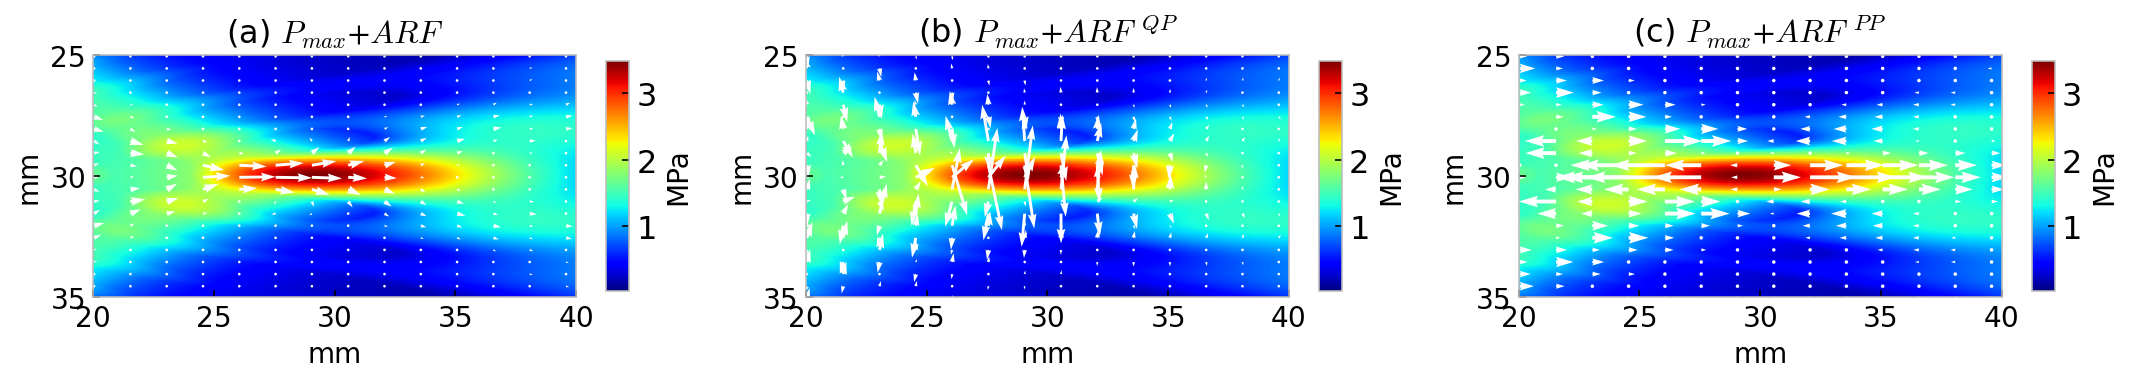

In [66]:
# define the x and y positions. They both span an axis of lenght 500
x_pos = np.linspace(0, 50, 500)
y_pos = np.linspace(0, 50, 500)

# set a quiver resolution, qres. If you choose a very small number, it will be 
# very hard to see anything due to crowdedness of all the force vectors. A good 
# number seems to be something between 10 and 20. I chose 15
qres = 15 
# define a meshgrid over those x and y positions. I am choosing a finer mesh in 
# y, so that we can see mroe force vectors along the y-axis. 
X, Y = np.meshgrid(x_pos[50::qres], y_pos[::int(qres/3)])



plt.figure(figsize=(15, 3))

plt.subplot(1, 3, 1)
plt.title(r'(a) $P_{max}\plus {ARF}$', fontsize=16)
plt.imshow(1e-6 * single_trxd.max_pressure[:, 50:], cmap='jet', 
          extent=(5, 50, 50, 0))
cbar = plt.colorbar(shrink=0.6, aspect=10)
cbar.set_label('MPa', fontsize=14)
cbar.ax.tick_params(labelsize=16)
plt.grid(False)
plt.quiver(X, Y, Fx_single[::int(qres/3), 50::qres], 
          Fy_single[::int(qres/3), 50::qres], scale=1.5e-2, 
          color='white', width=6e-3, alpha=1)
plt.grid(False)
plt.ylabel(r'mm', fontsize=14)
plt.xlabel(r'mm', fontsize=14)
plt.yticks(np.arange(25, 36, 5), fontsize=14)
plt.xticks(np.arange(20, 41, 5), fontsize=14)
plt.xlim(20, 40)
plt.ylim(35, 25)


plt.subplot(1, 3, 2)
plt.title(r'(b) $P_{max}\plus {ARF^{\ QP}}$', fontsize=16)
plt.imshow(1e-6 * single_trxd.max_pressure[:, 50:], cmap='jet', 
          extent=(5, 50, 50, 0))
cbar = plt.colorbar(shrink=0.6, aspect=10)
cbar.set_label('MPa', fontsize=14)
cbar.ax.tick_params(labelsize=16)
plt.grid(False)
plt.quiver(X, Y, Fx_single_quasi[::int(qres/3), 50::qres], 
          Fy_single_quasi[::int(qres/3), 50::qres], scale=4e-2, 
          color='white', width=6e-3, alpha=1)
plt.grid(False)
plt.ylabel(r'mm', fontsize=14)
plt.xlabel(r'mm', fontsize=14)
plt.yticks(np.arange(25, 36, 5), fontsize=14)
plt.xticks(np.arange(20, 41, 5), fontsize=14)
plt.xlim(20, 40)
plt.ylim(35, 25)


plt.subplot(1, 3, 3)
plt.title(r'(c) $P_{max}\plus {ARF^{\ PP}}$', fontsize=16)
plt.imshow(1e-6 * single_trxd.max_pressure[:, 50:], cmap='jet', 
          extent=(5, 50, 50, 0))
cbar = plt.colorbar(shrink=0.6, aspect=10)
cbar.set_label('MPa', fontsize=14)
cbar.ax.tick_params(labelsize=16)
plt.grid(False)
plt.quiver(X, Y, Fx_single_planar[::int(qres/3), 50::qres], 
          0, scale=0.5e-1, 
          color='white', width=8e-3, alpha=1)
plt.ylabel(r'mm', fontsize=14)
plt.xlabel(r'mm', fontsize=14)
plt.yticks(np.arange(25, 36, 5), fontsize=14)
plt.xticks(np.arange(20, 41, 5), fontsize=14)
plt.xlim(20, 40)
plt.ylim(35, 25)

plt.tight_layout()
#plt.savefig(figure_path + 'ARF_comparison_quiver', dpi=600)
plt.show()

### Pressure field under various transducer arrangements

Here we plot the pressure field for the cases of single, pair of antiparallel, and pair of orthogonal transducers. The aim is to show sharpening of the focal spot in the orthogonal setup in contrast to the other two regimes. 

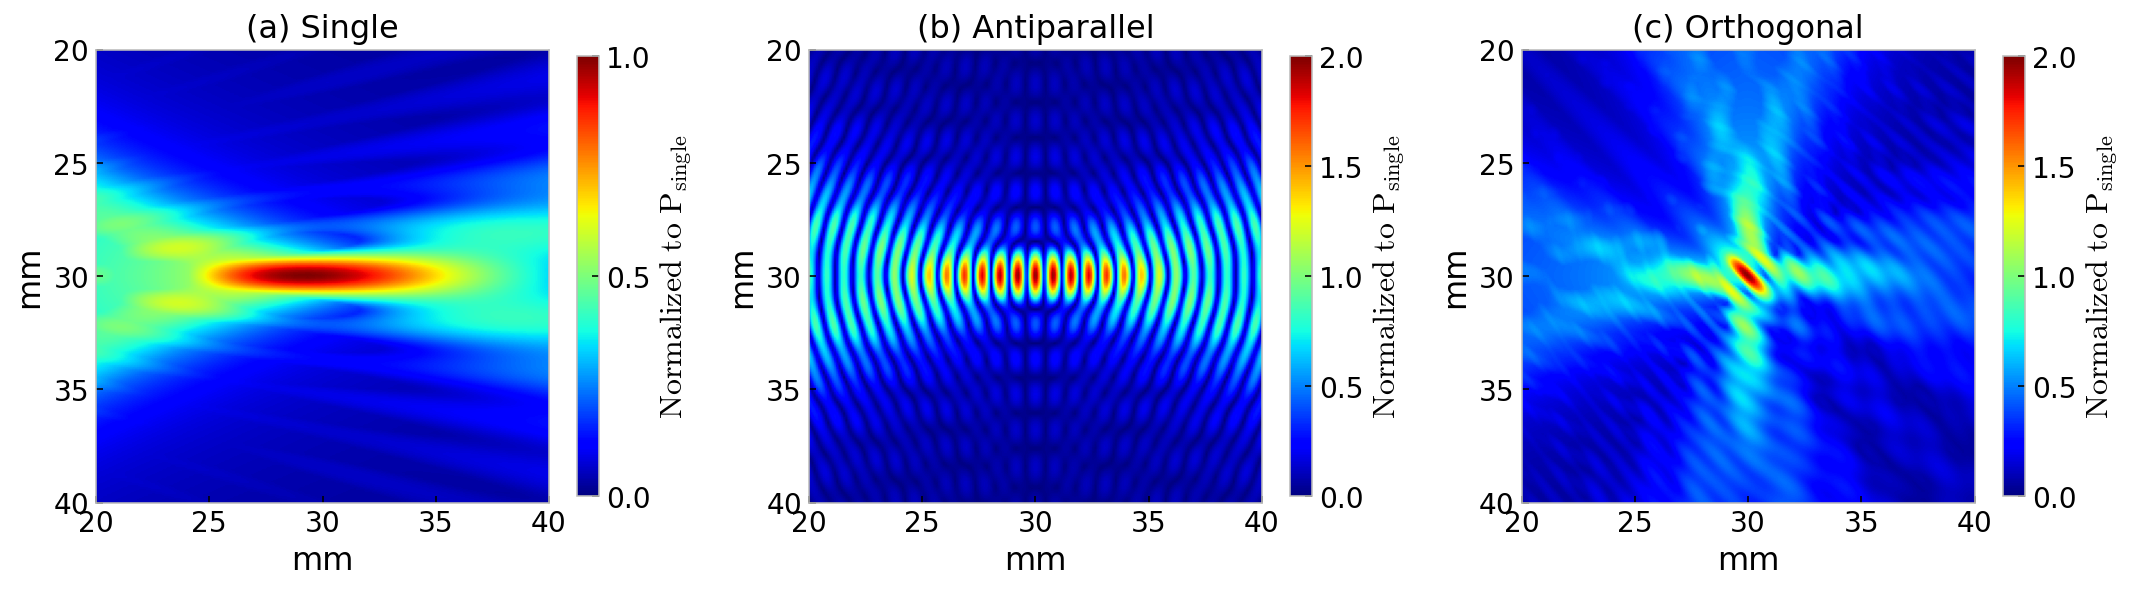

In [67]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('(a) Single', fontsize=16)
plt.imshow(single_trxd.max_pressure/ 
           np.max(single_trxd.max_pressure), cmap='jet', 
           extent=(0, 50, 50, 0), 
          vmin=0, vmax=1)
cbar = plt.colorbar(shrink=0.65, ticks=np.arange(0.0, 1.1, 0.5))
cbar.set_label(label='$\mathrm{Normalized\ to\ P_{single}}$', fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.xlim(20, 40)
plt.ylim(40, 20)
plt.ylabel(r'mm', fontsize=16)
plt.xlabel(r'mm', fontsize=16)
plt.xticks(np.arange(20, 41, 5))
plt.yticks(np.arange(20, 41, 5))
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(False)

plt.subplot(1, 3, 2)
plt.title('(b) Antiparallel', fontsize=16)
plt.imshow(antiparallel_trxd / np.max(single_trxd.max_pressure), 
           cmap='jet', extent=(10, 50, 50, 0), vmin=0, vmax=2)
cbar = plt.colorbar(shrink=0.65, ticks=np.arange(0, 2.1, 0.5))
cbar.set_label(label='$\mathrm{Normalized\ to\ P_{single}}$', fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.xlim(20, 40)
plt.ylim(40, 20)
plt.ylabel(r'mm', fontsize=16)
plt.xlabel(r'mm', fontsize=16)
plt.xticks(np.arange(20, 41, 5))
plt.yticks(np.arange(20, 41, 5))
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(False)

plt.subplot(1, 3, 3)
plt.title('(c) Orthogonal', fontsize=16)
plt.imshow(orthogonal_trxd.max_pressure / np.max(single_trxd.max_pressure), 
           cmap='jet', extent=(0, 50, 50, 0), vmin=0, vmax=2)
cbar = plt.colorbar(shrink=0.65, ticks=np.arange(0, 2.1, 0.5))
cbar.set_label(label='$\mathrm{Normalized\ to\ P_{single}}$', fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.xlim(20, 40)
plt.ylim(40, 20)
plt.ylabel(r'mm', fontsize=16)
plt.xlabel(r'mm', fontsize=16)
plt.xticks(np.arange(20, 41, 5))
plt.yticks(np.arange(20, 41, 5))
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(False)

plt.tight_layout()
#plt.savefig(figure_path + 'Pressure_comparison', dpi=600)
plt.show()

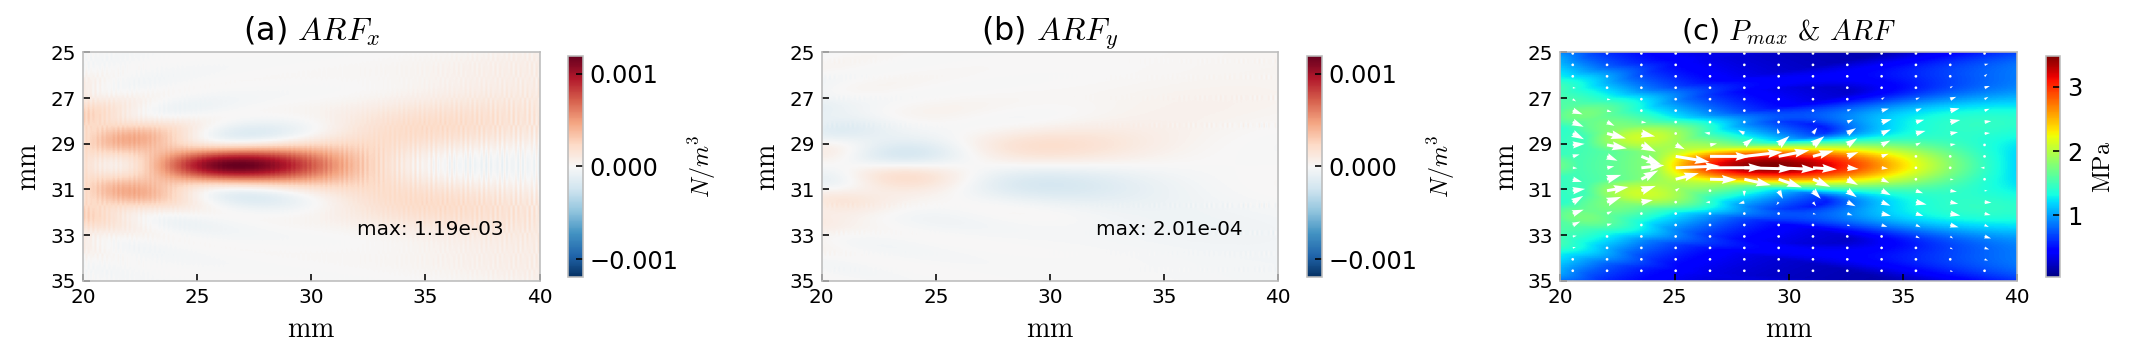

In [68]:
# redefine the meshgrid for these new plots, since they are cropped differently
X, Y = np.meshgrid(x_pos[col:-col:qres], y_pos[::int(qres/3)])

plt.figure(figsize=(15, 3))

plt.subplot(1, 3, 1)
plt.title('(a) $ARF_x$', fontsize=16)
plt.imshow(Fx_single[:, col:-col], cmap='RdBu_r', 
           extent=(col * dx * 1e3, (Nx - col) * dx * 1e3, Ny * dy * 1e3, 0), 
        vmin=Fx_single_min, vmax=Fx_single_max)
cbar = plt.colorbar(shrink=0.57, aspect=15)
cbar.set_label('$N/m^3$', fontsize=12)
cbar.ax.tick_params(labelsize=12)
plt.xlim(20, 40)
plt.ylim(35, 25)
plt.ylabel(r'$\mathrm{mm}$', fontsize=14)
plt.xlabel(r'$\mathrm{mm}$', fontsize=14)
plt.xticks(np.arange(20, 41, 5), fontsize=10)
plt.yticks(np.arange(35, 24, -2), fontsize=10)
plt.text(32, 33,
        'max: ' + '{:0.2e}'.format(Fx_single_max), 
        fontsize=10)
plt.grid(False)



plt.subplot(1, 3, 2)
plt.title('(b) $ARF_y$', fontsize=16)
plt.imshow(Fy_single[:, col:-col], cmap='RdBu_r', 
           extent=(col * dx * 1e3, (Nx - col) * dx * 1e3, Ny * dy * 1e3, 0), 
        vmin=Fx_single_min, vmax=Fx_single_max)
cbar = plt.colorbar(shrink=0.57, aspect=15)
cbar.set_label('$N/m^3$', fontsize=12)
cbar.ax.tick_params(labelsize=12)
plt.xlim(20, 40)
plt.ylim(35, 25)
plt.ylabel(r'$\mathrm{mm}$', fontsize=14)
plt.xlabel(r'$\mathrm{mm}$', fontsize=14)
plt.xticks(np.arange(20, 41, 5), fontsize=10)
plt.yticks(np.arange(35, 24, -2), fontsize=10)
plt.text(32, 33, 'max: ' + 
        '{:0.2e}'.format(Fy_single_max), fontsize=10)
plt.grid(False)

plt.subplot(1, 3, 3)
plt.title(r'(c) $P_{max}$ $\mathrm{&}$ $ARF$')
plt.imshow(1e-6 * single_trxd.max_pressure[:, col:-col], cmap='jet', 
          extent=(col * dx * 1e3, (Nx - col) * dx * 1e3, Ny * dy * 1e3, 0))
cbar = plt.colorbar(shrink=0.57, aspect=15)
cbar.set_label('$\mathrm{MPa}$', fontsize=12)
cbar.ax.tick_params(labelsize=12)
plt.grid(False)
plt.quiver(X, Y, Fx_single[::int(qres/3), col:-col:qres], 
          Fy_single[::int(qres/3), col:-col:qres], scale=1e-2, 
          color='white', width=6.5e-3, alpha=1)
plt.grid(False)
plt.ylabel(r'$\mathrm{mm}$', fontsize=14)
plt.xlabel(r'$\mathrm{mm}$', fontsize=14)
plt.xticks(np.arange(20, 41, 5), fontsize=10)
plt.yticks(np.arange(35, 24, -2), fontsize=10)
plt.xlim(20, 40)
plt.ylim(35, 25)

plt.tight_layout()
#plt.savefig(figure_path + 'complete_form_all.png', dpi=600)
plt.show()

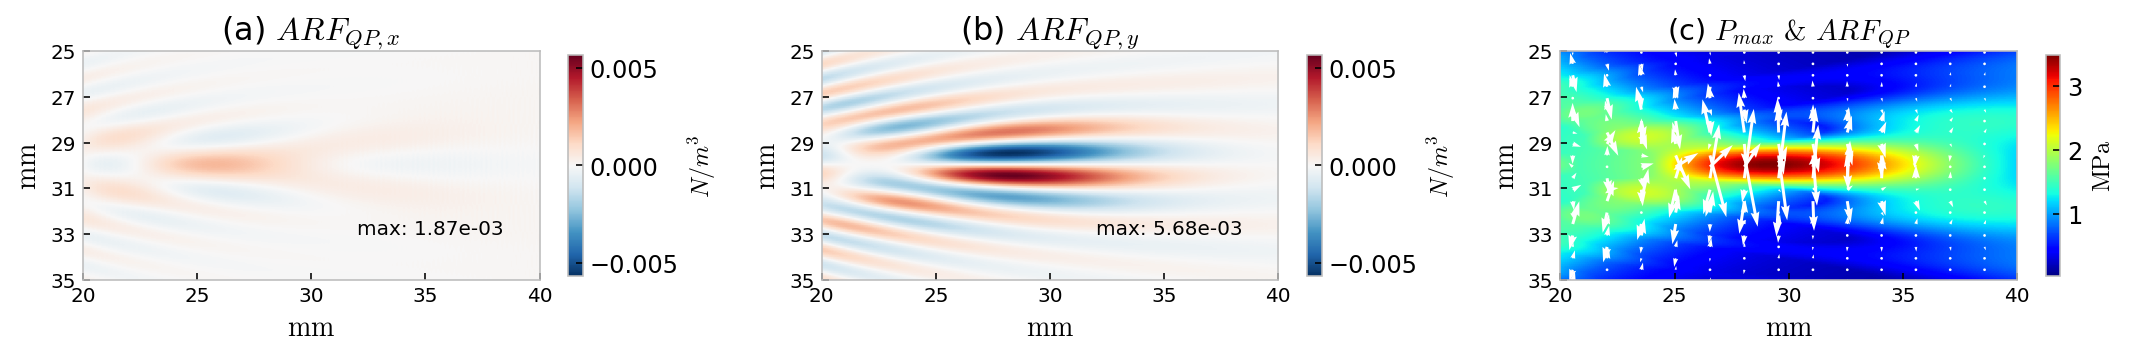

In [69]:
plt.figure(figsize=(15, 3))

plt.subplot(1, 3, 1)
plt.title('(a) $ARF_{QP, x}$', fontsize=16)
plt.imshow(Fx_single_quasi[:, col:-col], cmap='RdBu_r', 
           extent=(col * dx * 1e3, (Nx - col) * dx * 1e3, Ny * dy * 1e3, 0), 
        vmin=Fy_min_single_quasi, vmax=Fy_max_single_quasi)
cbar = plt.colorbar(shrink=0.57, aspect=15)
cbar.set_label('$N/m^3$', fontsize=12)
cbar.ax.tick_params(labelsize=12)
plt.xlim(20, 40)
plt.ylim(35, 25)
plt.ylabel(r'$\mathrm{mm}$', fontsize=14)
plt.xlabel(r'$\mathrm{mm}$', fontsize=14)
plt.xticks(np.arange(20, 41, 5), fontsize=10)
plt.yticks(np.arange(35, 24, -2), fontsize=10)
plt.text(32, 33,
        'max: ' + '{:0.2e}'.format(Fx_max_single_quasi), 
        fontsize=10)
plt.grid(False)



plt.subplot(1, 3, 2)
plt.title('(b) $ARF_{QP, y}$', fontsize=16)
plt.imshow(Fy_single_quasi[:, col:-col], cmap='RdBu_r', 
           extent=(col * dx * 1e3, (Nx - col) * dx * 1e3, Ny * dy * 1e3, 0), 
        vmin=Fy_min_single_quasi, vmax=Fy_max_single_quasi)
cbar = plt.colorbar(shrink=0.57, aspect=15)
cbar.set_label('$N/m^3$', fontsize=12)
cbar.ax.tick_params(labelsize=12)
plt.xlim(20, 40)
plt.ylim(35, 25)
plt.ylabel(r'$\mathrm{mm}$', fontsize=14)
plt.xlabel(r'$\mathrm{mm}$', fontsize=14)
plt.xticks(np.arange(20, 41, 5), fontsize=10)
plt.yticks(np.arange(35, 24, -2), fontsize=10)
plt.text(32, 33, 'max: ' + 
        '{:0.2e}'.format(Fy_max_single_quasi), fontsize=10)
plt.grid(False)

plt.subplot(1, 3, 3)
plt.title(r'(c) $P_{max}$ $\mathrm{&}$ $ARF_{QP}$')
plt.imshow(1e-6 * single_trxd.max_pressure[:, col:-col], cmap='jet', 
          extent=(col * dx * 1e3, (Nx - col) * dx * 1e3, Ny * dy * 1e3, 0))
cbar = plt.colorbar(shrink=0.57, aspect=15)
cbar.set_label('$\mathrm{MPa}$', fontsize=12)
cbar.ax.tick_params(labelsize=12)
plt.grid(False)
plt.quiver(X, Y, Fx_single_quasi[::int(qres/3), col:-col:qres], 
          Fy_single_quasi[::int(qres/3), col:-col:qres], scale=3.5e-2, 
          color='white', width=6.5e-3, alpha=1)
plt.grid(False)
plt.ylabel(r'$\mathrm{mm}$', fontsize=14)
plt.xlabel(r'$\mathrm{mm}$', fontsize=14)
plt.xticks(np.arange(20, 41, 5), fontsize=10)
plt.yticks(np.arange(35, 24, -2), fontsize=10)
plt.xlim(20, 40)
plt.ylim(35, 25)

plt.tight_layout()
#plt.savefig(figure_path + 'quasi_planar_all.png', dpi=600)
plt.show()

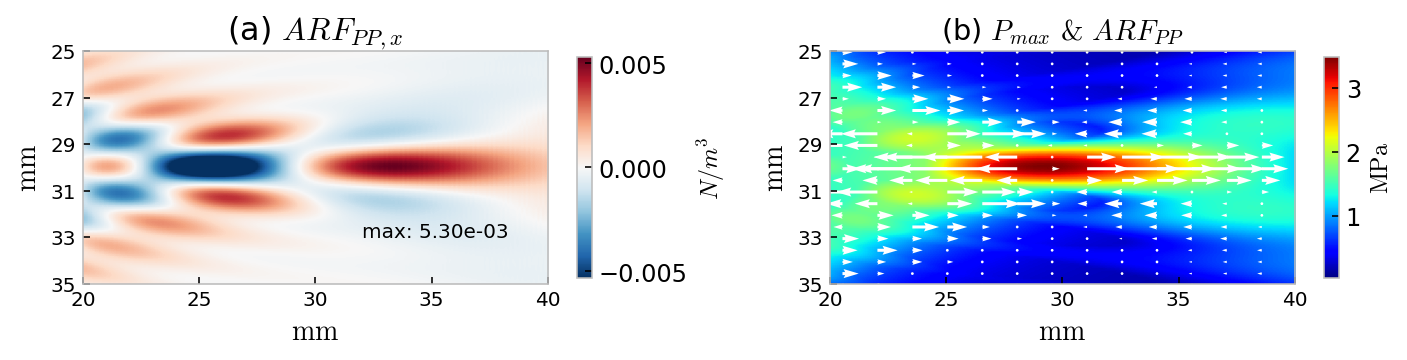

In [70]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.title('(a) $ARF_{PP, x}$', fontsize=16)
plt.imshow(Fx_single_planar[:, col:-col], cmap='RdBu_r', extent=(col * dx * 1e3, (Nx - col) * dx * 1e3, Ny * dy * 1e3, 0), 
        vmin=Fx_min_single_planar, vmax=Fx_max_single_planar)
cbar = plt.colorbar(shrink=0.57, aspect=15)
cbar.set_label('$N/m^3$', fontsize=12)
cbar.ax.tick_params(labelsize=12)
plt.xlim(20, 40)
plt.ylim(35, 25)
plt.ylabel(r'$\mathrm{mm}$', fontsize=14)
plt.xlabel(r'$\mathrm{mm}$', fontsize=14)
plt.xticks(np.arange(20, 41, 5), fontsize=10)
plt.yticks(np.arange(35, 24, -2), fontsize=10)
plt.text(32, 33,
        'max: ' + '{:0.2e}'.format(Fx_max_single_planar), 
        fontsize=10)
plt.grid(False)


plt.subplot(1, 2, 2)
plt.title(r'(b) $P_{max}$ $\mathrm{&}$ $ARF_{PP}$')
plt.imshow(1e-6 * single_trxd.max_pressure[:, col:-col], cmap='jet', 
          extent=(col * dx * 1e3, (Nx - col) * dx * 1e3, Ny * dy * 1e3, 0))
cbar = plt.colorbar(shrink=0.57, aspect=15)
cbar.set_label('$\mathrm{MPa}$', fontsize=12)
cbar.ax.tick_params(labelsize=12)
plt.grid(False)
plt.quiver(X, Y, Fx_single_planar[::int(qres/3), col:-col:qres], 
          0 * Fx_single_planar[::int(qres/3), col:-col:qres], scale=4e-2, 
          color='white', width=6.5e-3, alpha=1)
plt.grid(False)
plt.ylabel(r'$\mathrm{mm}$', fontsize=14)
plt.xlabel(r'$\mathrm{mm}$', fontsize=14)
plt.xticks(np.arange(20, 41, 5), fontsize=10)
plt.yticks(np.arange(35, 24, -2), fontsize=10)
plt.xlim(20, 40)
plt.ylim(35, 25)

plt.tight_layout()
#plt.savefig(figure_path + 'purely_planar_all.png', dpi=600)
plt.show()

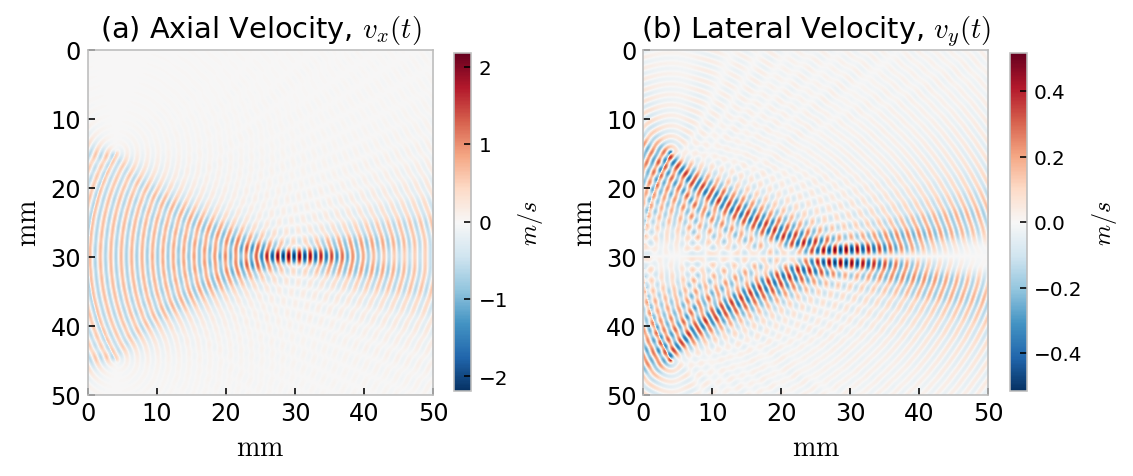

In [71]:
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.title('(a) Axial Velocity, $v_x(t)$')
plt.imshow(single_trxd.vx[Nt-1], cmap='RdBu_r', extent=(0, Nx * dx * 1e3, Ny * dy * 1e3, 0))
plt.xlabel(r'$\mathrm{mm}$', fontsize=14)
plt.ylabel(r'$\mathrm{mm}$', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbar = plt.colorbar(shrink=0.5)
cbar.set_label(r'$m/s$')
plt.grid(False)

plt.subplot(1, 2, 2)
plt.title('(b) Lateral Velocity, $v_y(t)$')
plt.imshow(single_trxd.vy[Nt-1], cmap='RdBu_r', extent=(0, Nx * dx * 1e3, Ny * dy * 1e3, 0))
plt.xlabel(r'$\mathrm{mm}$', fontsize=14)
plt.ylabel(r'$\mathrm{mm}$', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
cbar = plt.colorbar(shrink=0.5)
cbar.set_label(r'$m/s$')
plt.grid(False)

plt.tight_layout()
#plt.savefig(figure_path + 'vx_vy_single', dpi=600)
plt.show()

# 6.&nbsp;References

1. Prieur F, Sapozhnikov OA. Modeling of the acoustic radiation force in elastography. J Acoust Soc Am. 2017 Aug;142(2):947. doi: 10.1121/1.4998585. PMID: 28863603.
2. Fabrice Prieur and Stefan Catheline , "Simulation of shear wave elastography imaging using the toolbox “k-Wave”", Proceedings of Meetings on Acoustics 29, 020002 (2016) https://doi.org/10.1121/2.0000398
3. K. Firouzi and B. T. Khuri-Yakub, "A $k$ -Space Pseudospectral Method for Elastic Wave Propagation in Heterogeneous Anisotropic Media," in IEEE Transactions on Ultrasonics, Ferroelectrics, and Frequency Control, vol. 64, no. 4, pp. 749-760, April 2017, doi: 10.1109/TUFFC.2017.2653063.
4. Bruus H. Acoustofluidics 7: The acoustic radiation force on small particles. Lab Chip. 2012 Mar 21;12(6):1014-21. doi: 10.1039/c2lc21068a. Epub 2012 Feb 21. PMID: 22349937.